In [3]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12612\457341533.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https

In [4]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()


# Calculate Weekly and Monthly Total Traffic

In [5]:
# Import estimated daily Volume
DV=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_DV_feb19.csv')
DV=DV.drop(['level_0','index'],axis=1)
DV.head()

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,2014,E,Thursday,5,6191,37.916293,-122.026658,323.429092
1,2014,N,Thursday,5,6274,37.919106,-122.065131,44.209732
2,2014,S,Thursday,5,6002,37.916497,-122.027719,51.190216
3,2014,S,Thursday,5,6127,37.917992,-122.065518,44.209732
4,2014,S,Thursday,5,6192,37.884941,-122.077718,20.941452


In [6]:
check=DV.loc[DV['TDV']==0]
check

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV


In [7]:
DV.isnull().sum()

year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [8]:
# import pop, CBD and Strava
stv=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Sc_Stv_pop_CBD.csv')
stv=stv.rename(columns={'tdg_id':'matched_seg_id'})
stv.tail(2)

,Unnamed: 0.1,matched_seg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
5702,5702,66187.0,2014.0,5478,Eric_Fischer893,S,34.266245,-118.313146,308135633.0,13291814.0,NaN,NaN,NaN,NaN,0.0,POINT (155306.06124027242 -415248.5251424038),5304.864322
5703,5703,64988.0,2014.0,5571,Eric_Fischer986,E,34.066455,-118.469556,307724323.0,203650462.0,NaN,NaN,NaN,NaN,0.0,POINT (141264.8749155821 -437655.1388520058),6901.823725


In [9]:
stv1=stv[['matched_seg_id','year','stv_rec_ratio','popden']]
stv1.shape

(5704, 4)

In [10]:
DV1=pd.merge(DV,stv1, left_on=['matched_seg_id','year'],right_on=['matched_seg_id','year'],how='inner')
DV1.shape

(6775, 10)

In [11]:
DV['matched_seg_id'].nunique(),stv['matched_seg_id'].nunique(),DV1['matched_seg_id'].nunique()

(2605, 3608, 2604)

In [12]:
# Now find the short term sites that did not match
common = stv.merge(DV,on=['matched_seg_id', 'year'])
ch=stv[(~stv.matched_seg_id.isin(common.matched_seg_id))]
ch.head()

,Unnamed: 0.1,matched_seg_id,year,Unnamed: 0,ID,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
22,22,110786.0,2014.0,22,SLO_Co100,N,35.450025,-120.905457,308323714.0,122271531.0,2045.0,15.0,2030.0,NaN,0.992665,POINT (-82111.86795962877 -284820.6632723808),373.455910
41,41,109452.0,2014.0,41,SLO_Co117,N,35.107667,-120.623545,307306862.0,173192915.0,4540.0,80.0,4460.0,NaN,0.982379,POINT (-56796.84413261634 -323046.3841695278),3474.266127
49,49,5909.0,2014.0,49,WC12,N,37.901597,-122.060658,309729214.0,697808495.0,375.0,45.0,330.0,NaN,0.880000,POINT (-180939.03470852147 -10792.114636834245),5677.316051
105,105,157903.0,2014.0,105,Oakland79,W,37.810756,-122.261471,309650108.0,417728797.0,8555.0,1615.0,6940.0,NaN,0.811222,POINT (-198809.3760047524 -20485.919830330648),18336.352348
124,124,111375.0,2014.0,124,SLO_Co99,S,35.449348,-120.905954,308323712.0,867731945.0,3050.0,20.0,3030.0,NaN,0.993443,POINT (-82157.67138367904 -284895.3626244436),367.863889


In [13]:
ch['matched_seg_id'].unique()

array([110786., 109452.,   5909., ...,  55028.,  66187.,  64988.])

In [14]:
# Lets separate sites that have Strava RR 
DV1['popden'].isnull().sum(),DV1['stv_rec_ratio'].isnull().sum()
# it seems 13 sites hass popden missing or zero pop density and 3673  have missing SRR

(0, 0)

In [15]:
DV1['popden'].fillna(1, inplace=True)

In [16]:
DV1p1=DV1.loc[DV1['stv_rec_ratio']>=0]
DV1p2=DV1[DV1['stv_rec_ratio'].isnull()]

In [17]:
DV1.shape,DV1p1.shape,DV1p2.shape 

((6775, 10), (6775, 10), (0, 10))

In [18]:
# Now estimate SRR using the formula.
# a=0.96967
# b=-0.00303
# c=0.02395
# DV1p2['stv_rec_ratio']=a+b*np.sqrt(DV1p2['popden'])+c*np.log(DV1p2['CBD Distance'])
# DV1p2.head()

In [19]:
# now combine with rest of the data that have already SRR
DV3=DV1p1
DV3.shape

(6775, 10)

In [20]:
# Now calculate the WWI index using WWI= 0.54311-0.04492* ln(population Density) + 0.60716 *〖"(Strava Recreational Ratio)" 〗^𝟐
a=0.54311
b=-0.04492
c=0.60716
DV3['WWI']=a+b*np.log(DV3['popden'])+c*np.power(DV3['stv_rec_ratio'],2)

In [21]:
# Split the data by WWI threshold to apply DOW factor
w_g1=DV3.loc[DV3['WWI']<=0.40]
w_g2=DV3.loc[DV3['WWI']>0.40]
w_g2.tail(2)

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,popden,WWI
6773,2019,W,Saturday,6,80666,39.140724,-120.155743,48.103565,0.937500,226.820272,0.833094
6774,2019,W,Saturday,7,80797,39.237589,-120.028389,229.169103,0.977744,674.983342,0.830905


In [22]:
# read DOW factor
DOW=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Final Factor/Final_DOW_Factor.csv')
DOW.head()

,Unnamed: 0,Day of Week,Average_Group_DOW_Factor,criteria
0,0,Monday,0.157756,WWI<=0.40
1,1,Tuesday,0.172408,WWI<=0.40
2,2,Wednesday,0.168993,WWI<=0.40
3,3,Thursday,0.161938,WWI<=0.40
4,4,Friday,0.145688,WWI<=0.40


In [23]:
DOW_g1=DOW.loc[DOW['criteria']=='WWI<=0.40']
DOW_g2=DOW.loc[DOW['criteria']=='WWI>0.40']

In [24]:
# Calculate weekly Volume for group 1
wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
wg1_DV1=pd.DataFrame({'agge_Weekly_Volume' : wg1_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['TDV'].sum()}).reset_index()
wg1_DV1f=pd.DataFrame({'agge_factor' : wg1_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Average_Group_DOW_Factor'].sum()}).reset_index()
wg1_DV1r=pd.merge(wg1_DV1,wg1_DV1f, on=['year','Leg','month','matched_seg_id','Lat','Long'], how='inner')
wg1_DV1r['Weekly_Volume']=wg1_DV1r['agge_Weekly_Volume']/wg1_DV1r['agge_factor']
wg1_DV1rf=pd.DataFrame({'TWV' : wg1_DV1r.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()

In [25]:
c=wg1_DV.loc[wg1_DV['TDV']==0]
c1=wg1_DV1.loc[wg1_DV1['agge_Weekly_Volume']==0]
c.shape,c1.shape

((0, 14), (0, 7))

In [26]:
# Calculate weekly Volume for group 2
wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
wg2_DV2=pd.DataFrame({'agge_Weekly_Volume' : wg2_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['TDV'].sum()}).reset_index()
wg2_DV2f=pd.DataFrame({'agge_factor' : wg2_DV.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Average_Group_DOW_Factor'].sum()}).reset_index()
wg2_DV2r=pd.merge(wg2_DV2,wg2_DV2f, on=['year','Leg','month','matched_seg_id','Lat','Long'], how='inner')
wg2_DV2r['Weekly_Volume']=wg2_DV2r['agge_Weekly_Volume']/wg2_DV2r['agge_factor']
wg2_DV2rf=pd.DataFrame({'TWV' : wg2_DV2r.groupby(['year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()

In [27]:
c=wg2_DV.loc[wg2_DV['TDV']==0]
c1=wg2_DV2.loc[wg2_DV2['agge_Weekly_Volume']==0]
c.shape,c1.shape

((0, 14), (0, 7))

In [28]:
wg2_DV.head()

,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,popden,WWI,Unnamed: 0,Average_Group_DOW_Factor,criteria
0,2014,E,Thursday,5,6191,37.916293,-122.026658,323.429092,0.967676,3574.017778,0.744142,3,0.126624,WWI>0.40
1,2014,N,Thursday,5,6274,37.919106,-122.065131,44.209732,0.793651,6404.168560,0.531838,3,0.126624,WWI>0.40
2,2014,S,Thursday,5,6002,37.916497,-122.027719,51.190216,0.953779,3637.433372,0.727140,3,0.126624,WWI>0.40
3,2014,S,Thursday,5,6127,37.917992,-122.065518,44.209732,0.740741,6241.750126,0.483700,3,0.126624,WWI>0.40
4,2014,S,Thursday,5,6192,37.884941,-122.077718,20.941452,0.943190,3911.200091,0.711684,3,0.126624,WWI>0.40


In [29]:
# Apply factor to obtain weekly Total Volume Volume
# wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
# wg1_DV['Weekly_Volume']=wg1_DV['TDV']/wg1_DV['Average_Group_DOW_Factor']
# wg1_DV1=pd.DataFrame({'TWV' : wg1_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()
# wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
# wg2_DV['Weekly_Volume']=wg2_DV['TDV']/wg2_DV['Average_Group_DOW_Factor']
# wg2_DV2=pd.DataFrame({'TWV' : wg2_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()


In [30]:
# c=wg2_DV2.loc[wg2_DV2['TWV']==0]
# c1=wg1_DV1.loc[wg1_DV1['TWV']==0]
# c.shape,c1.shape

In [31]:
# combine these three group of estimated daily volume together
WV=pd.concat([wg1_DV1rf,wg2_DV2rf],axis=0).reset_index()
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070
1,1,2014,E,1,53102,34.035474,-118.265867,2668.161684
2,2,2014,E,2,60365,34.094931,-118.308130,3024.141066
3,3,2014,E,5,63070,34.029300,-118.409925,1902.043304
4,4,2014,E,6,63070,34.029300,-118.409925,1426.532478


In [32]:
WV['matched_seg_id'].nunique()

2604

In [33]:
wg2_DV.isnull().sum()

year                        0
Leg                         0
Day of Week                 0
month                       0
matched_seg_id              0
Lat                         0
Long                        0
TDV                         0
stv_rec_ratio               0
popden                      0
WWI                         0
Unnamed: 0                  0
Average_Group_DOW_Factor    0
criteria                    0
dtype: int64

In [34]:
# Now divide TWV by 7 to get the weekley average volume
WV['AWV']=WV['TWV']/7
WV['year'] = WV['year'].apply(np.int64)
WV['month'] = WV['month'].apply(np.int64)
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296
1,1,2014,E,1,53102,34.035474,-118.265867,2668.161684,381.165955
2,2,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152
3,3,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472
4,4,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354


In [35]:
# Now calculate the number of days in data collection month and multiple average weekly volume (AWV) to get monthly total volume
# create dummy day column to get the date and days in month
WV['day']=1
cols=["year","month","day"]
WV['date'] = WV[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
WV['date'] = pd.to_datetime(WV['date'], errors='coerce')
WV['days_in_month'] = WV['date'].dt.days_in_month
WV.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31
1,1,2014,E,1,53102,34.035474,-118.265867,2668.161684,381.165955,1,2014-01-01,31
2,2,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152,1,2014-02-01,28
3,3,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472,1,2014-05-01,31
4,4,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354,1,2014-06-01,30


In [36]:
WV['MTT']=WV['AWV']*WV['days_in_month']
WV['MTT'].describe()

count     3686.000000
mean      4270.196022
std       5317.266638
min        116.840044
25%       1150.348661
50%       2422.798661
75%       5156.610979
max      53942.358415
Name: MTT, dtype: float64

In [37]:
WV.isnull().sum()

index             0
year              0
Leg               0
month             0
matched_seg_id    0
Lat               0
Long              0
TWV               0
AWV               0
day               0
date              0
days_in_month     0
MTT               0
dtype: int64

In [38]:
check=WV.loc[WV['MTT']==0]
check

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT


<AxesSubplot: >

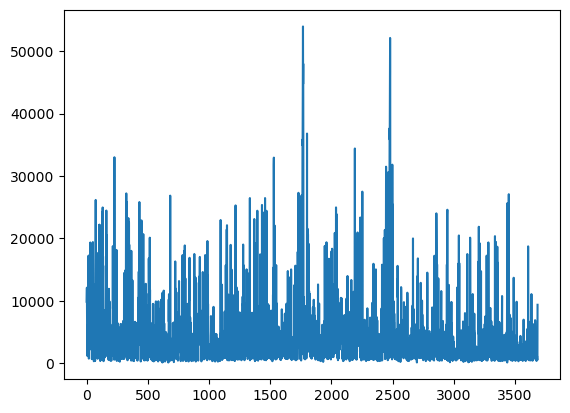

In [39]:
WV['MTT'].plot()

In [40]:
check=WV.loc[WV['MTT']>200000]
check

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT


# Now Estimate Annual Total Traffic

In [41]:
# read the moy factor
MOY=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Final Factor/Final_MOY_Factor.csv')
MOY.head()

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
0,0,1,0.067719,seasonal_factor<=2.4
1,1,2,0.071112,seasonal_factor<=2.4
2,2,3,0.080148,seasonal_factor<=2.4
3,3,4,0.087425,seasonal_factor<=2.4
4,4,5,0.091053,seasonal_factor<=2.4


In [42]:
MOY['Criteria'].unique()

array(['seasonal_factor<=2.4', '2.4<seasonal_factor<=5',
       'seasonal_factor>5'], dtype=object)

In [43]:
# Now split the data by group
moy_g1=MOY.loc[MOY['Criteria']=='seasonal_factor<=2.4']
moy_g2=MOY.loc[MOY['Criteria']=='2.4<seasonal_factor<=5']
moy_g3=MOY.loc[MOY['Criteria']=='seasonal_factor>5']
moy_g3.head(2)

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
24,0,1,0.021449,seasonal_factor>5
25,1,2,0.018644,seasonal_factor>5


In [44]:
# Calculate the seasonality factor and check how many sites have data to calculate it
# get June/July/August Data
dos678=DV[(DV['month']>5) &(DV['month']<9)]
dos678=dos678[['matched_seg_id','year','Leg','TDV']]
dos678c=pd.DataFrame({'Average Daily Count678' : dos678.groupby(['matched_seg_id','year','Leg'])['TDV'].mean()}).reset_index()
dos678c.head()

,matched_seg_id,year,Leg,Average Daily Count678
0,6447,2014,S,30.070687
1,6893,2015,N,71.779543
2,7119,2017,E,64.427432
3,7175,2017,N,241.573342
4,7211,2016,W,152.579892


In [45]:
# get December/January/February Data
dos12=DV.loc[DV['month']==12]
dos1=DV.loc[DV['month']==1]
dos3=DV.loc[DV['month']==2]
dos1213=pd.concat([dos12,dos1,dos3],axis=0)
dos1213=dos1213[['matched_seg_id','year',"Leg",'TDV']]
dos12131=pd.DataFrame({'Average Daily Count12131' : dos1213.groupby(['matched_seg_id','year','Leg'])['TDV'].mean()}).reset_index()
dos12131.head()

,matched_seg_id,year,Leg,Average Daily Count12131
0,2183,2018,N,23.948430
1,2185,2018,W,28.837404
2,2186,2018,E,42.576426
3,5820,2019,S,72.248933
4,5861,2019,N,72.248933


In [46]:
seasonal_data=pd.merge(dos12131,dos678c, left_on=['matched_seg_id','year','Leg'],right_on=['matched_seg_id','year','Leg'],how='inner')
seasonal_data['seasonal_factor']=seasonal_data['Average Daily Count678']/seasonal_data['Average Daily Count12131']
seasonal_data=seasonal_data[['matched_seg_id','year','Leg','seasonal_factor']]
seasonal_data.head()

,matched_seg_id,year,Leg,seasonal_factor


In [47]:
# It seems none of the sites have data to calculate the seasonality, therefore used geohrahic classification to assign the
#seasonality group. Use the closest distance to assign the seasonal group
g1=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group1.shp')
g1['group']='seasonal_factor<=2.4'
g2=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group2.shp')
g2['group']='2.4<seasonal_factor<=5'
g3=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Revised_Seasonality/Group3.shp')
g3['group']='seasonal_factor>5'
# combine all
s_g=pd.concat([g1,g2,g3],axis=0)
#s_g['group'] = s_g['group'].apply(np.int64)
s_g.head()

,Field1,ID,latitude,longitude,location,road,city,county,state,country,Average_se,geometry,group
0,0,671,37.791160,-122.459440,urban,Bay Area Ridge Trail,San Francisco,None,California,United States,1.268874,POINT (-122.45944 37.79116),seasonal_factor<=2.4
1,1,1127,37.796165,-122.419490,urban,Broadway,San Francisco,None,California,United States,1.012863,POINT (-122.41949 37.79617),seasonal_factor<=2.4
2,2,2415,37.774200,-122.436295,urban,Fell Street,San Francisco,None,California,United States,1.407406,POINT (-122.43629 37.77420),seasonal_factor<=2.4
3,3,2694,33.683254,-117.662080,urban,Torino Drive,None,Orange County,California,United States,1.359999,POINT (-117.66208 33.68325),seasonal_factor<=2.4
4,4,2695,33.672590,-117.651860,urban,Serrano Road,None,Orange County,California,United States,1.515797,POINT (-117.65186 33.67259),seasonal_factor<=2.4


In [48]:
s_g.groupby(['group'])['ID'].count()

group
2.4<seasonal_factor<=5      6
seasonal_factor<=2.4      152
seasonal_factor>5           6
Name: ID, dtype: int64

In [49]:
s_g.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
WV1 = gpd.GeoDataFrame(WV, geometry=gpd.points_from_xy(WV.Long, WV.Lat))
WV1.head()

,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (-118.26823 34.03673)
1,1,2014,E,1,53102,34.035474,-118.265867,2668.161684,381.165955,1,2014-01-01,31,11816.144599,POINT (-118.26587 34.03547)
2,2,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152,1,2014-02-01,28,12096.564263,POINT (-118.30813 34.09493)
3,3,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472,1,2014-05-01,31,8423.334630,POINT (-118.40993 34.02930)
4,4,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354,1,2014-06-01,30,6113.710619,POINT (-118.40993 34.02930)


In [51]:
crs = {'init': 'epsg:4326'}
WV2 = gpd.GeoDataFrame(WV1, crs=crs, geometry = 'geometry')
WV2.head()

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (-118.26823 34.03673)
1,1,2014,E,1,53102,34.035474,-118.265867,2668.161684,381.165955,1,2014-01-01,31,11816.144599,POINT (-118.26587 34.03547)
2,2,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152,1,2014-02-01,28,12096.564263,POINT (-118.30813 34.09493)
3,3,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472,1,2014-05-01,31,8423.334630,POINT (-118.40993 34.02930)
4,4,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354,1,2014-06-01,30,6113.710619,POINT (-118.40993 34.02930)


In [52]:
# project the co-ordinate
WV2_proj = WV2.to_crs(epsg=3310).reset_index()
s_g_proj = s_g.to_crs(epsg=3310).reset_index()

In [53]:
def nearest_point(point, point2):
    idx = point2.geometry.distance(point).idxmin()
    return point2.loc[idx,'group']

In [54]:
WV2_proj['group'] = WV2_proj.geometry.apply(nearest_point, point2=s_g_proj)
WV2_proj.head()

,level_0,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
0,0,0,2014,E,1,53084,34.036725,-118.268227,2223.468070,317.638296,1,2014-01-01,31,9846.787165,POINT (159906.171 -440632.482),seasonal_factor<=2.4
1,1,1,2014,E,1,53102,34.035474,-118.265867,2668.161684,381.165955,1,2014-01-01,31,11816.144599,POINT (160126.551 -440767.229),seasonal_factor<=2.4
2,2,2,2014,E,2,60365,34.094931,-118.308130,3024.141066,432.020152,1,2014-02-01,28,12096.564263,POINT (156106.916 -434243.408),seasonal_factor<=2.4
3,3,3,2014,E,5,63070,34.029300,-118.409925,1902.043304,271.720472,1,2014-05-01,31,8423.334630,POINT (146837.500 -441685.442),seasonal_factor<=2.4
4,4,4,2014,E,6,63070,34.029300,-118.409925,1426.532478,203.790354,1,2014-06-01,30,6113.710619,POINT (146837.500 -441685.442),seasonal_factor<=2.4


In [55]:
# Now split the data by group
m_g1=WV2_proj.loc[WV2_proj['group']=='seasonal_factor<=2.4']
m_g2=WV2_proj.loc[WV2_proj['group']=='2.4<seasonal_factor<=5']
m_g3=WV2_proj.loc[WV2_proj['group']=='seasonal_factor>5']
m_g3.head(2)

,level_0,index,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
68,68,68,2015,E,8,8904,38.87892,-120.019933,1357.058416,193.865488,1,2015-08-01,31,6009.830129,POINT (-1726.986 95881.088),seasonal_factor>5
69,69,69,2015,E,9,8904,38.87892,-120.019933,86.612514,12.373216,1,2015-09-01,30,371.196487,POINT (-1726.986 95881.088),seasonal_factor>5


In [56]:
# Calculate Annual Volume for group 1
mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
mg1_DV1=pd.DataFrame({'agge_monthly_Volume' : mg1_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg1_DV1f=pd.DataFrame({'agge_factor' : mg1_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg1_DV1r=pd.merge(mg1_DV1,mg1_DV1f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg1_DV1r['Annual_Volume']=mg1_DV1r['agge_monthly_Volume']/mg1_DV1r['agge_factor']
mg1_DV1rf=pd.DataFrame({'ATT' : mg1_DV1r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [57]:
mg1_DV.shape,mg1_DV1.shape

((3520, 19), (3438, 6))

In [58]:
c=mg1_DV.loc[mg1_DV['MTT']==0]
c1=mg1_DV1.loc[mg1_DV1['agge_monthly_Volume']==0]
c.shape,c1.shape

((0, 19), (0, 6))

In [59]:
# Calculate Annual Volume for group 1
mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
mg2_DV2=pd.DataFrame({'agge_monthly_Volume' : mg2_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg2_DV2f=pd.DataFrame({'agge_factor' : mg2_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg2_DV2r=pd.merge(mg2_DV2,mg2_DV2f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg2_DV2r['Annual_Volume']=mg2_DV2r['agge_monthly_Volume']/mg2_DV2r['agge_factor']
mg2_DV2rf=pd.DataFrame({'ATT' : mg2_DV2r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [60]:
# Calculate Annual Volume for group 1
mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
mg3_DV3=pd.DataFrame({'agge_monthly_Volume' : mg3_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg3_DV3f=pd.DataFrame({'agge_factor' : mg3_DV.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg3_DV3r=pd.merge(mg3_DV3,mg3_DV3f, on=['year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg3_DV3r['Annual_Volume']=mg3_DV3r['agge_monthly_Volume']/mg3_DV3r['agge_factor']
mg3_DV3rf=pd.DataFrame({'ATT' : mg3_DV3r.groupby(['year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [61]:
# Now apply the MOY factor to get ATT
# Apply factor to obtain daily Volume
# mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
# mg1_DV['Annual_Volume']=mg1_DV['MTT']/mg1_DV['Average_Group_MOY_Factor']
# mg1_DV1=pd.DataFrame({'ATT' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
# mg2_DV['Annual_Volume']=mg2_DV['MTT']/mg2_DV['Average_Group_MOY_Factor']
# mg2_DV2=pd.DataFrame({'ATT' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
# mg3_DV['Annual_Volume']=mg3_DV['MTT']/mg3_DV['Average_Group_MOY_Factor']
# mg3_DV3=pd.DataFrame({'ATT' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg3_DV3.head()

In [62]:
# mg1_DV.tail(10)

In [63]:
# combine these three group of estimated Annual volume together
AV=pd.concat([mg1_DV1rf,mg2_DV2rf,mg3_DV3rf],axis=0).reset_index()
AV.ATT = AV.ATT.round()
AV.head()

,index,year,Leg,matched_seg_id,Lat,Long,ATT
0,0,2014,E,6191,37.916293,-122.026658,124231.0
1,1,2014,E,6234,37.885158,-122.077300,17640.0
2,2,2014,E,49197,34.049795,-117.815552,11809.0
3,3,2014,E,49209,34.043425,-117.846269,13160.0
4,4,2014,E,53084,34.036725,-118.268227,145406.0


In [64]:
# bring back the location id
idf=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/short_term_clean_data_2014_2019.csv')
idf=idf[['ID',"matched_seg_id"]]
idf1=idf.drop_duplicates(subset=["matched_seg_id"], keep='first')
idf1.shape

(4264, 2)

In [65]:
AV1=pd.merge(AV, idf1, on=['matched_seg_id'], how='inner')
AV1.shape

(3578, 8)

In [66]:
# now check unique location for each year
AV1.groupby(['year'])['ID'].nunique()

year
2014    106
2015    144
2016    490
2017    306
2018    454
2019    220
Name: ID, dtype: int64

In [67]:
AV1['ID'].nunique()

1350

In [68]:
AV=AV.loc[AV['Lat']!=0]
AV['ATT in Million']=AV['ATT']/1000000
AV['AADB']=AV['ATT']/365
AV.head()

,index,year,Leg,matched_seg_id,Lat,Long,ATT,ATT in Million,AADB
0,0,2014,E,6191,37.916293,-122.026658,124231.0,0.124231,340.358904
1,1,2014,E,6234,37.885158,-122.077300,17640.0,0.017640,48.328767
2,2,2014,E,49197,34.049795,-117.815552,11809.0,0.011809,32.353425
3,3,2014,E,49209,34.043425,-117.846269,13160.0,0.013160,36.054795
4,4,2014,E,53084,34.036725,-118.268227,145406.0,0.145406,398.372603


In [101]:
c=AV.loc[AV['ATT']==0]
c.shape

(0, 9)

In [102]:
AV['ATT in Million'].max()

0.718001

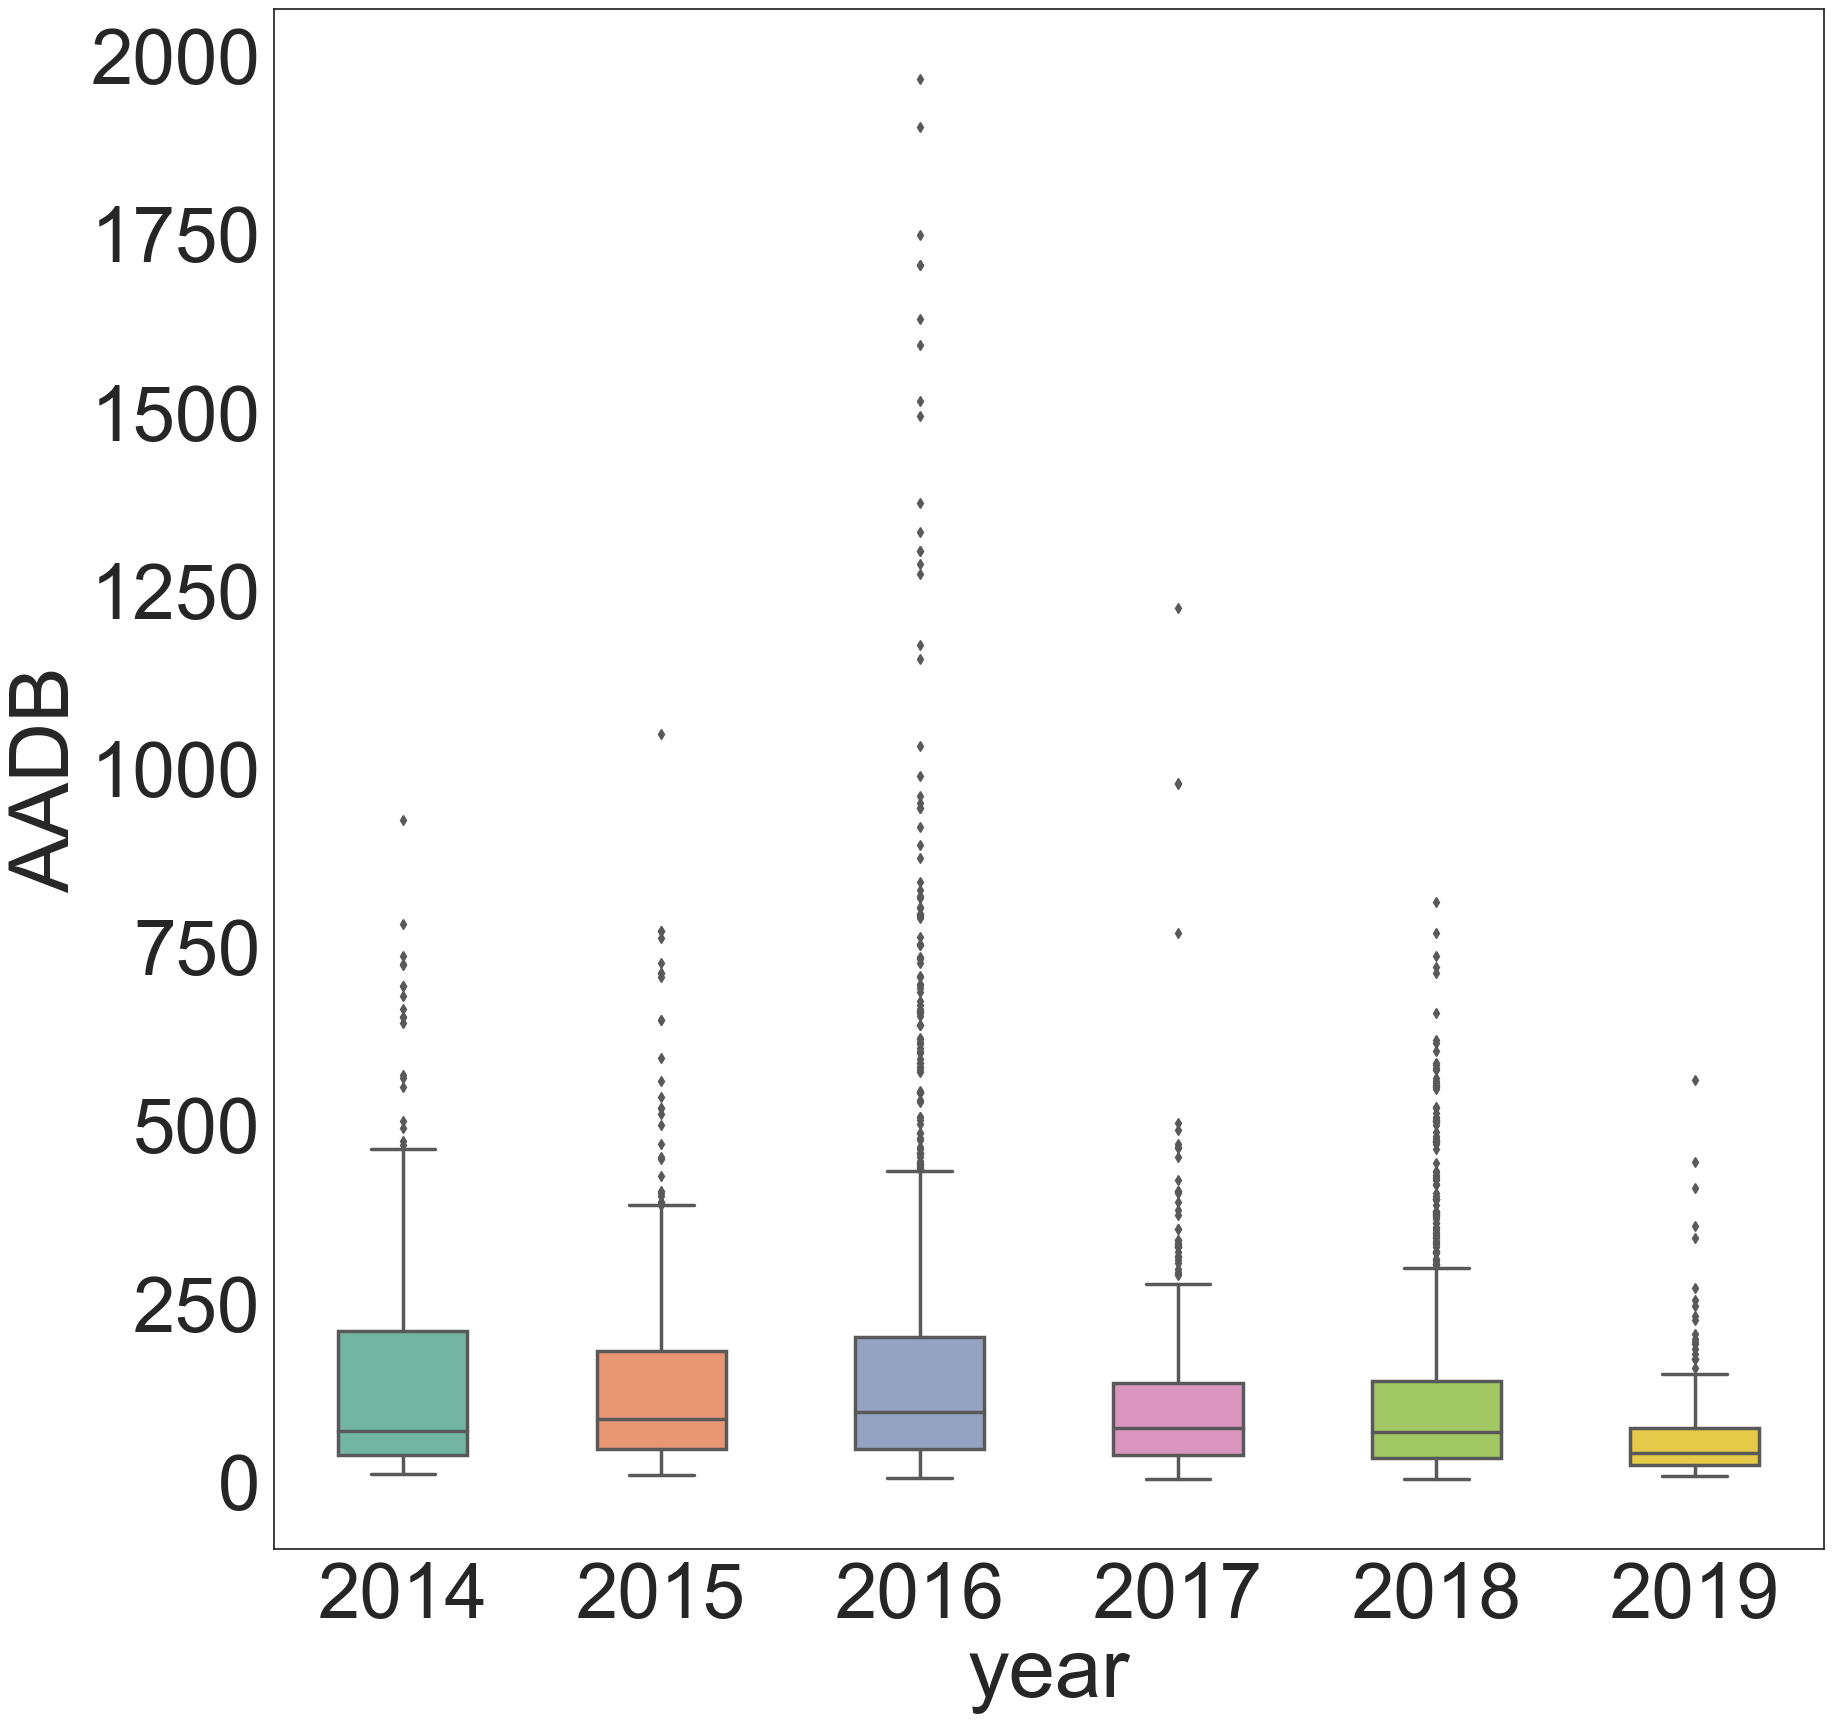

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,20)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
ax=sns.boxplot( x=AV["year"], y=AV["AADB"],width=0.5,linewidth=2.5,orient="v",palette="Set2" );
#sns.stripplot(data=AV, x="year", y="ATT in Million", dodge=True, ax=ax)
plt.show()

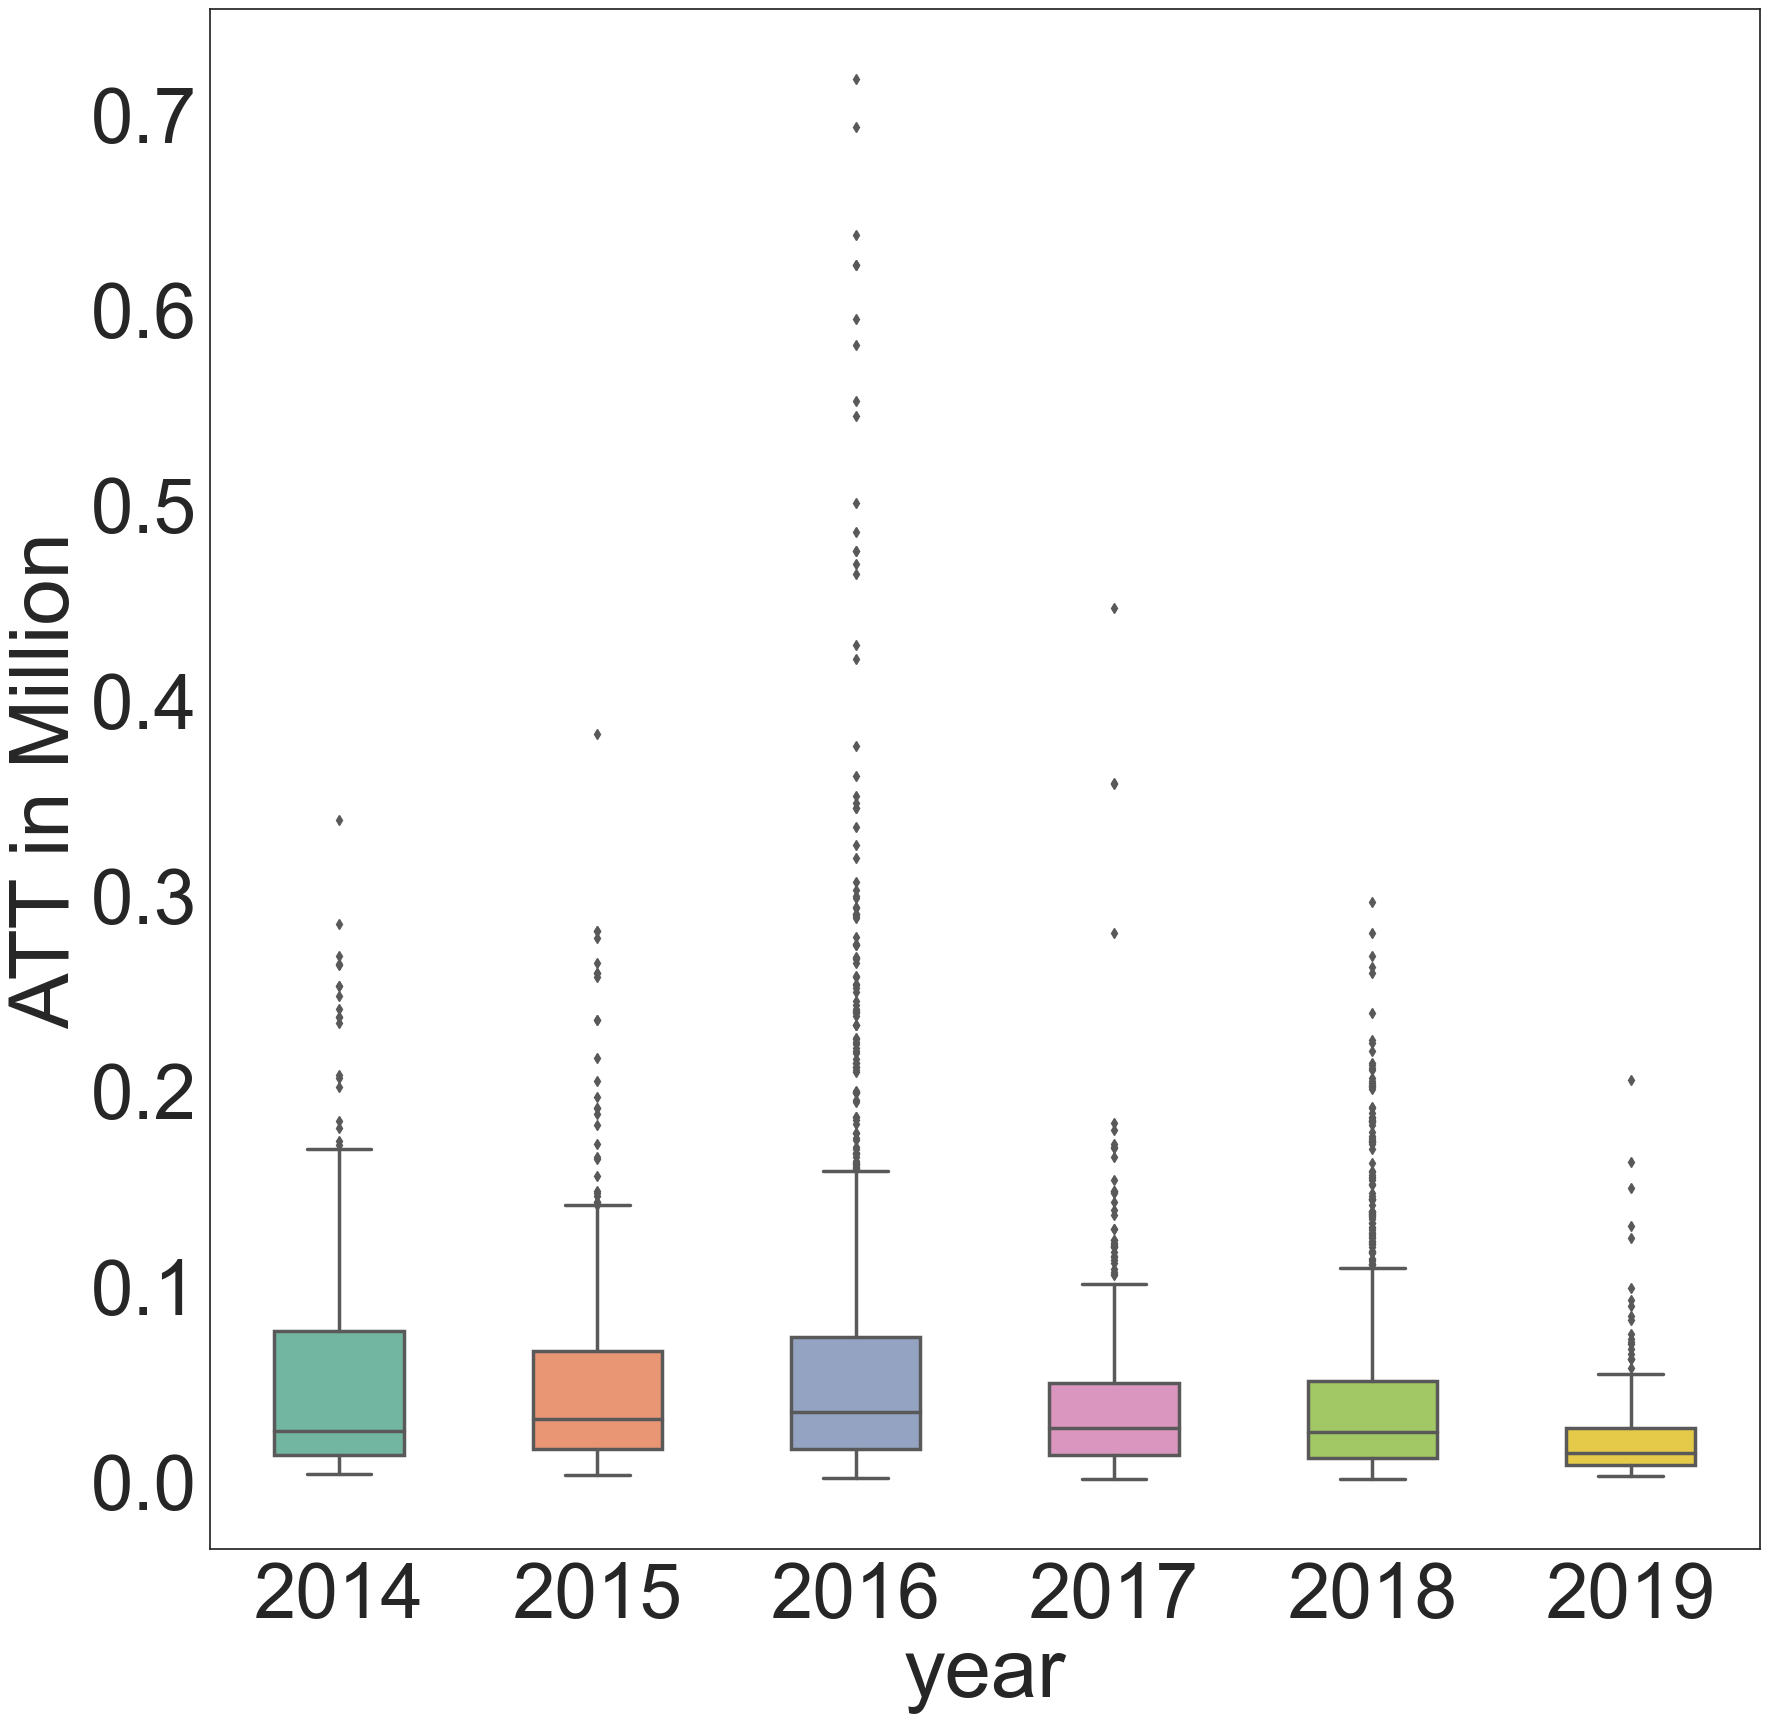

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,20)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
ax=sns.boxplot( x=AV["year"], y=AV["ATT in Million"],width=0.5,linewidth=2.5,orient="v",palette="Set2" );
#sns.stripplot(data=AV, x="year", y="ATT in Million", dodge=True, ax=ax)
plt.show()

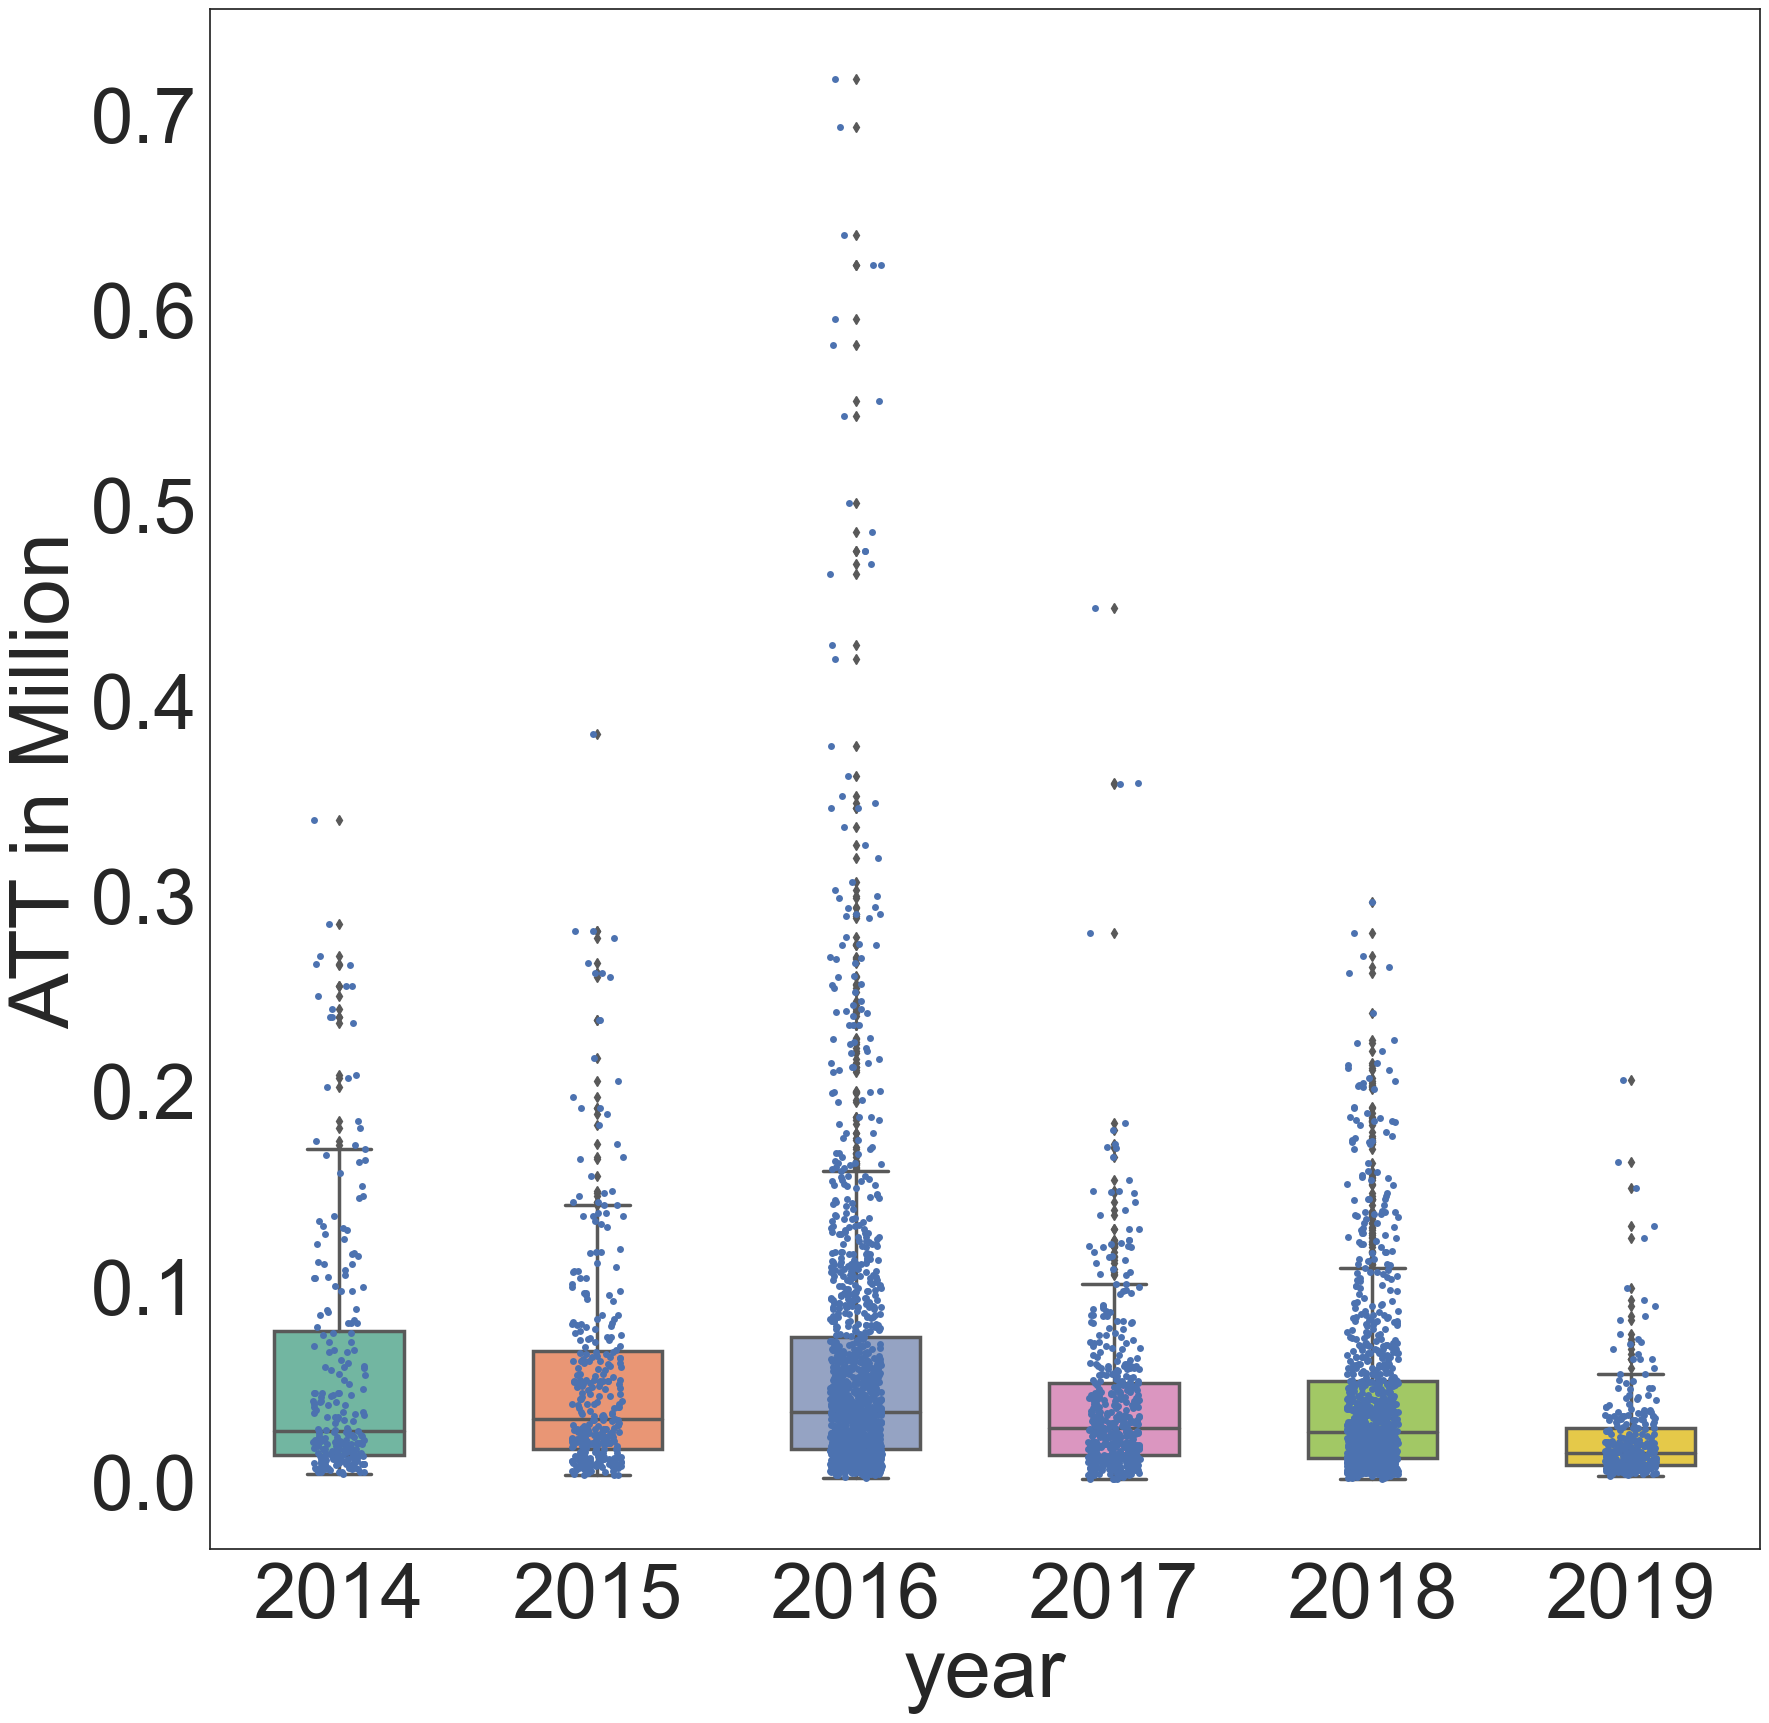

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,20)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
ax=sns.boxplot( x=AV["year"], y=AV["ATT in Million"],width=0.5,linewidth=2.5,orient="v",palette="Set2" );
sns.stripplot(data=AV, x="year", y="ATT in Million", dodge=True, ax=ax)
plt.show()

In [106]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(rc={'figure.figsize':(20,20)})
# sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
# # filter the data and exclude the sites that have more than million count
# data=AV.loc[AV['ATT in Million']<=1]
# sns.boxplot( x=data["year"], y=data["ATT in Million"],width=0.50,linewidth=2.5,orient="v",palette="Set2");
# plt.show()

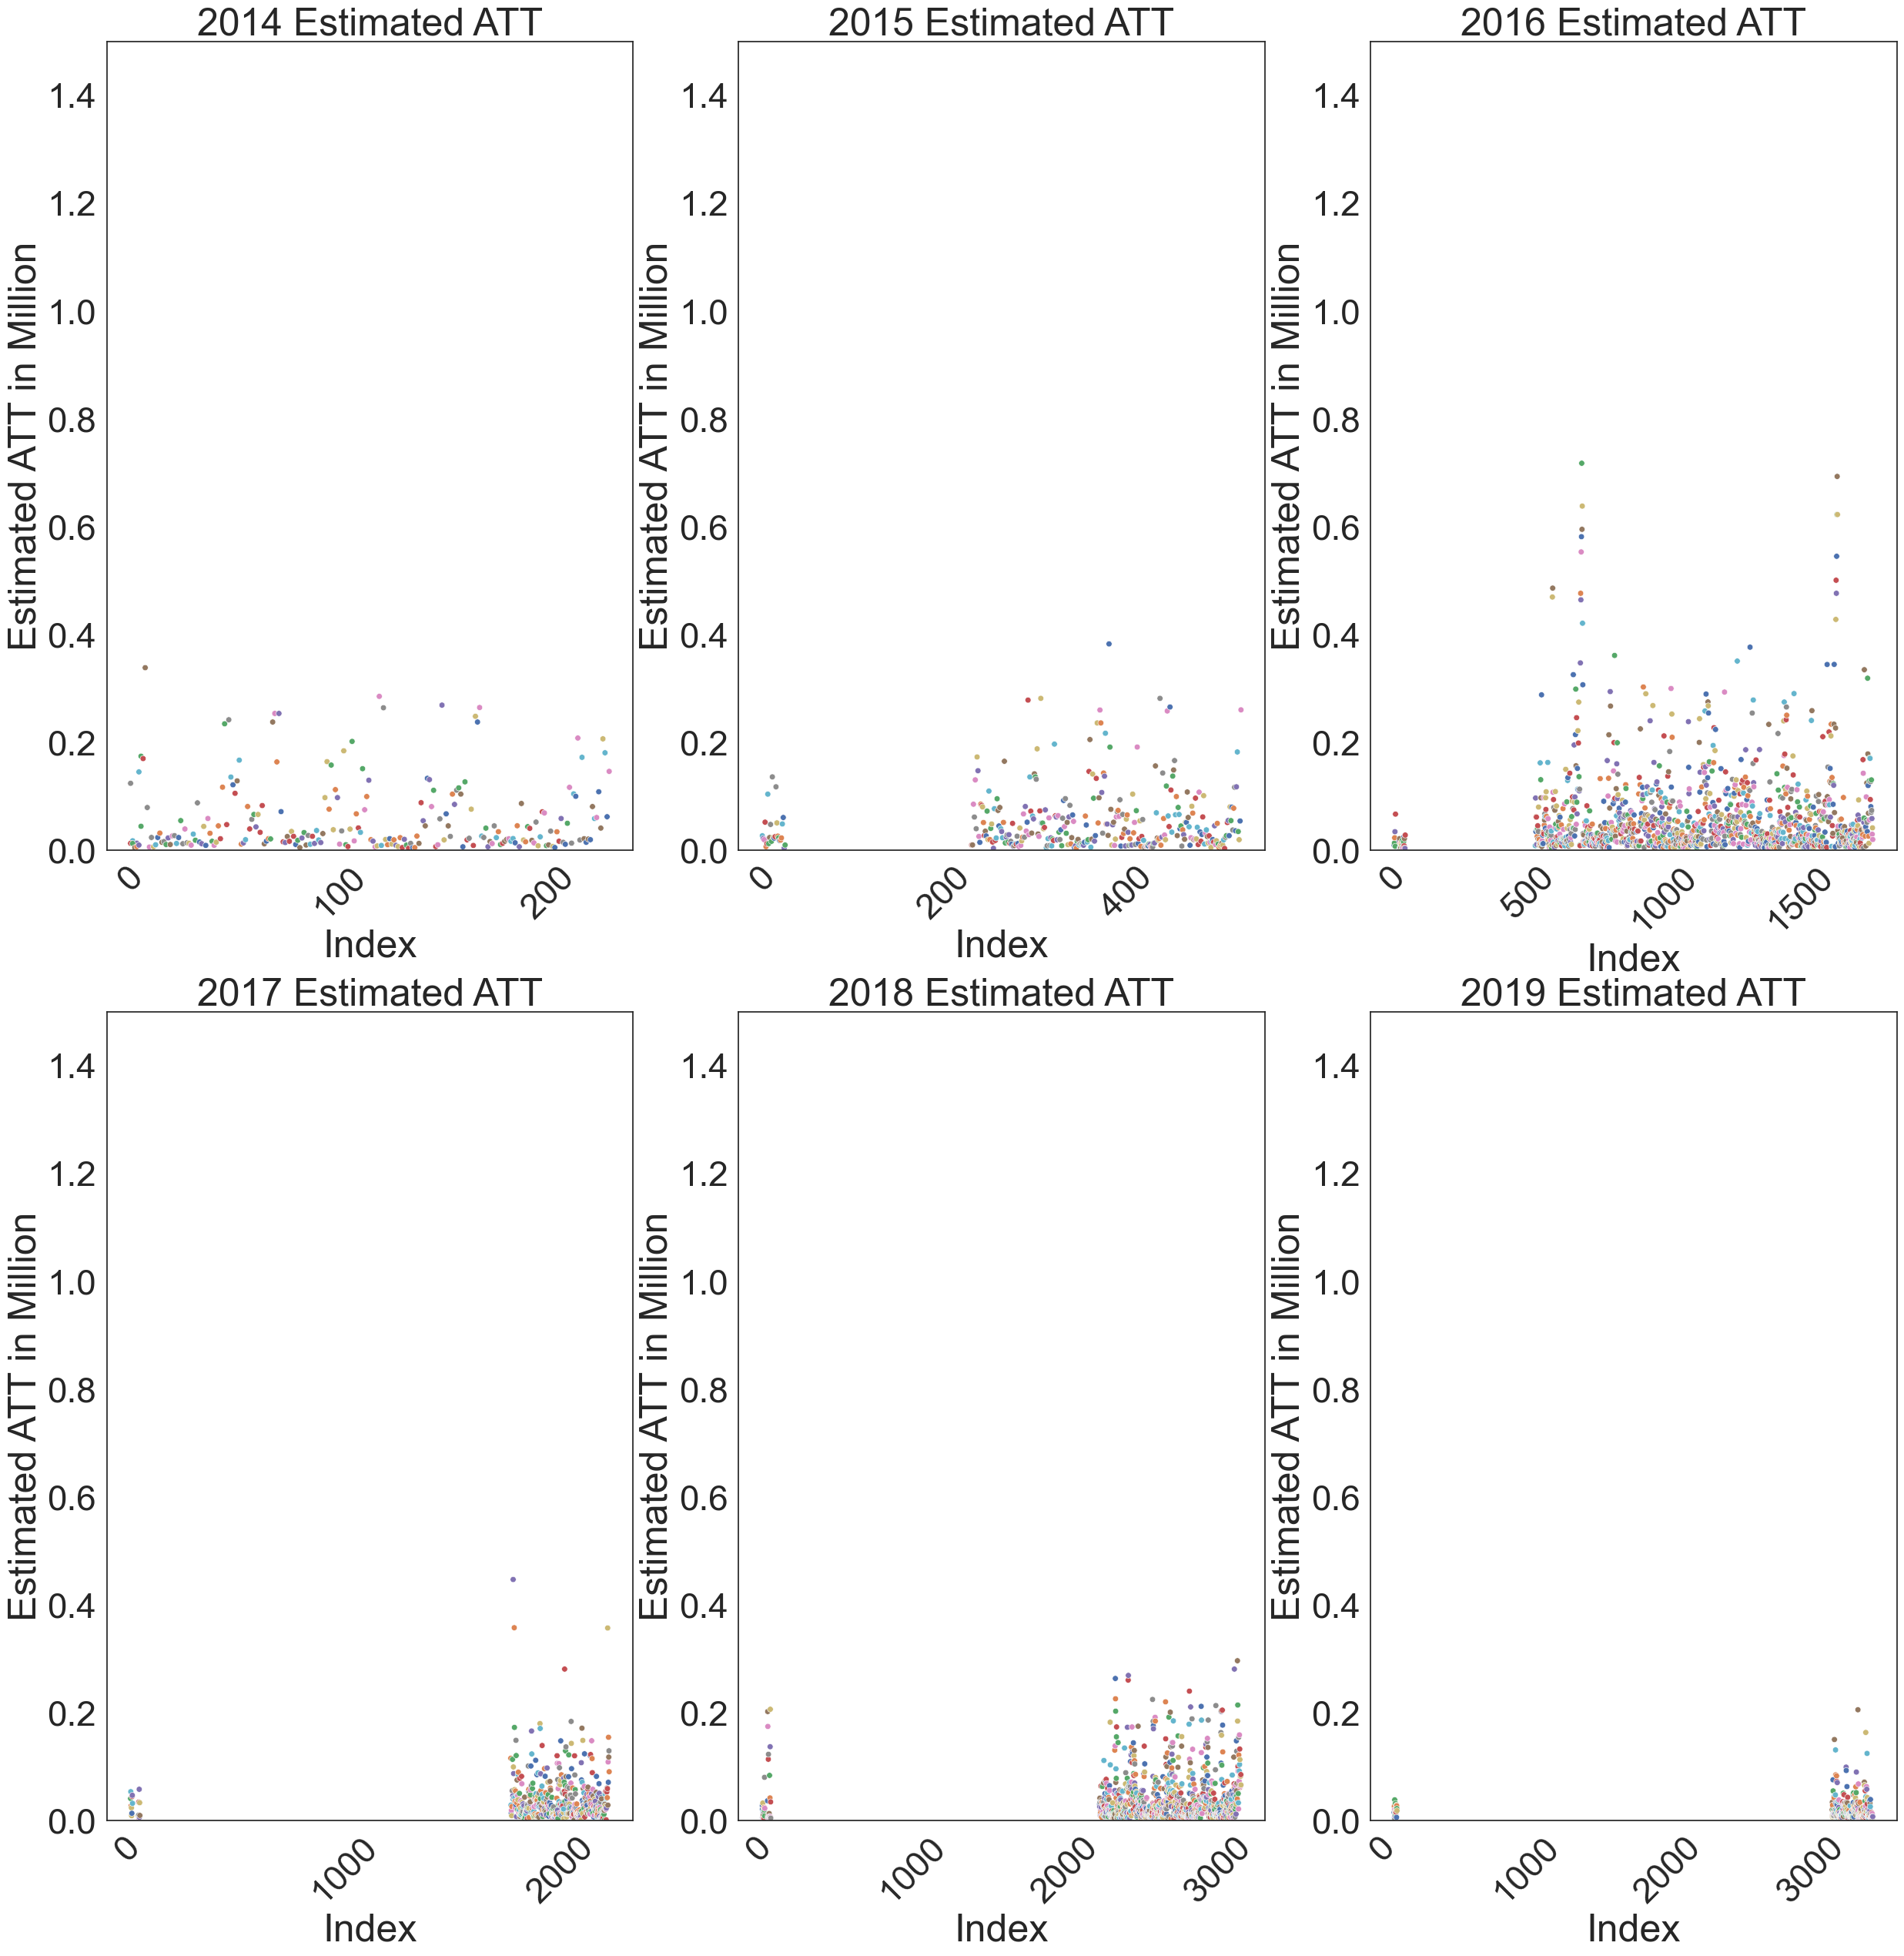

In [107]:
sns.set(rc={'figure.figsize':(30,30)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=3, color_codes=False, rc=None)
#sns.set(font_scale=3.0)
#sns.set_theme(style='white')
import seaborn as sns
d14=AV.loc[AV['year']==2014]
d15=AV.loc[AV['year']==2015]
d16=AV.loc[AV['year']==2016]
d17=AV.loc[AV['year']==2017]
d18=AV.loc[AV['year']==2018]
d19=AV.loc[AV['year']==2019]
fig, ax = plt.subplots(2,3) 

ax1 = sns.scatterplot(x=d14['index'],y=d14['ATT in Million'],hue=d14['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.scatterplot(x=d15['index'],y=d15['ATT in Million'],hue=d15['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.scatterplot(x=d16['index'],y=d16['ATT in Million'],hue=d16['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[0,2]) 
plt.xticks(rotation = 'vertical')
ax4 = sns.scatterplot(x=d17['index'],y=d17['ATT in Million'],hue=d17['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,0]) 
plt.xticks(rotation = 'vertical')
ax5 = sns.scatterplot(x=d18['index'],y=d18['ATT in Million'],hue=d18['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,1])
plt.xticks(rotation = 'vertical')
ax6 = sns.scatterplot(x=d19['index'],y=d19['ATT in Million'],hue=d19['matched_seg_id'],palette="deep",
                       markers=True,marker="o",s=30,ax=ax[1,2]) 
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()


ax1.set_ylim([0, 1.5])
ax2.set_ylim([0, 1.5])
ax3.set_ylim([0, 1.5])
ax4.set_ylim([0, 1.5])
ax5.set_ylim([0, 1.5])
ax6.set_ylim([0, 1.5])
ax1.ticklabel_format(style='plain', axis='both')
ax2.ticklabel_format(style='plain', axis='both')
ax3.ticklabel_format(style='plain', axis='both')
ax4.ticklabel_format(style='plain', axis='both')
ax5.ticklabel_format(style='plain', axis='both')
ax6.ticklabel_format(style='plain', axis='both')

ax1.title.set_text('2014 Estimated ATT')
ax2.title.set_text('2015 Estimated ATT')
ax3.title.set_text('2016 Estimated ATT')
ax4.title.set_text('2017 Estimated ATT')
ax5.title.set_text('2018 Estimated ATT')
ax6.title.set_text('2019 Estimated ATT')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45)

ax1.set_ylabel('Estimated ATT in Million' )
ax1.set_xlabel('Index')
ax2.set_ylabel('Estimated ATT in Million' )
ax2.set_xlabel('Index')
ax3.set_ylabel('Estimated ATT in Million' )
ax3.set_xlabel('Index')
ax4.set_ylabel('Estimated ATT in Million' )
ax4.set_xlabel('Index')
ax5.set_ylabel('Estimated ATT in Million' )
ax5.set_xlabel('Index')
ax6.set_ylabel('Estimated ATT in Million' )
ax6.set_xlabel('Index')
plt.show()

In [108]:
AV.groupby(['year'])['Leg'].count()

year
2014     236
2015     324
2016    1273
2017     474
2018     964
2019     307
Name: Leg, dtype: int64

In [109]:
AV['Leg'].count()

3578

In [110]:
AV.groupby(['year','Leg'])['ATT'].describe().round(0).astype(int)

count   mean     std   min    25%    50%    75%     max
year Leg                                                         
2014 E       65  57384   66504  5981  13671  27163  79320  338721
     N       53  62868   69560  4930  15675  30982  97714  253821
     S       46  54724   70511  3813   9550  20203  84102  285525
     W       72  54803   62953  5084  15501  24368  63977  264856
2015 E       83  55455   56001  3623  18843  34898  73481  281814
     N       77  57652   61707  3436  15454  33683  65514  260205
     S       86  59227   70534  5408  13135  29688  68767  382834
     W       78  44737   41867  3430  17057  32864  59431  260508
2016 E      323  69025  105733  3511  16946  31525  73730  718001
     N      341  57038   59869  1686  16059  37385  73467  302922
     S      295  62256   63247  3076  19308  40619  83700  376769
     W      314  64112   96138  3332  16203  32276  68224  693513
2017 E      103  48014   61727  2717  16692  30153  54478  447217
     N      138  35963   32542  3021  12536  26183  46528  179972
     S      115  43313   45611  1255  13192  26896  59116  281049
     W      118  39108   42651  1510  17510  28240  45294  357280
2018 E      246  45121   48731  1900  13394  27882  57759  269297
     N      260  39947   44900  1654  11208  23020  49984  224730
     S      235  39932   44292  2985  11400  23263  48650  240072
     W      223  44967   51259  1280  12214  26717  54834  296537
2019 E       75  24634   26952  4149   9320  14389  29018  150349
     N       79  19610   17274  3043   8730  14488  27379   99170
     S       76  23066   26650  3840   9012  17084  27557  205571
     W       77  22034   25572  3599   7712  13223  25849  163462

In [111]:
AV.groupby(['year'])['matched_seg_id'].count()

year
2014     236
2015     324
2016    1273
2017     474
2018     964
2019     307
Name: matched_seg_id, dtype: int64

In [112]:
AV.groupby(['year'])['matched_seg_id'].nunique()

year
2014     227
2015     320
2016    1218
2017     472
2018     939
2019     294
Name: matched_seg_id, dtype: int64

In [113]:
AV['matched_seg_id'].nunique()

2604

In [114]:
AV.shape

(3578, 9)

In [83]:
# Save the estimation
AV.to_csv('H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT_march1.csv',index=False)

In [502]:
# Now join with independent variables
indv=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Independent Variables/smart4_final_output_Mar17_2023_geojson/smart4_final_output_Mar17d.geojson')
indv['forward_trip_count_2018']=indv['forward_trip_count_2018'].astype(str).astype(int)
indv['forward_trip_count_2019']=indv['forward_trip_count_2019'].astype(str).astype(int)
indv['forward_trip_count']=indv[['forward_trip_count_2018', 'forward_trip_count_2019']].mean(axis=1)


indv['reverse_trip_count_2018']=indv['reverse_trip_count_2018'].astype(str).astype(int)
indv['reverse_trip_count_2019']=indv['reverse_trip_count_2019'].astype(str).astype(int)
indv['reverse_trip_count']=indv[['reverse_trip_count_2018','reverse_trip_count_2019']].mean(axis=1)


indv['forward_commute_trip_count_2018']=indv['forward_commute_trip_count_2018'].astype(str).astype(int)
indv['forward_commute_trip_count_2019']=indv['forward_commute_trip_count_2019'].astype(str).astype(int)
indv['forward_commute_trip_count']=indv[['forward_commute_trip_count_2018','forward_commute_trip_count_2019']].mean(axis=1)

indv['reverse_commute_trip_count_2018']=indv['reverse_commute_trip_count_2018'].astype(str).astype(int)
indv['reverse_commute_trip_count_2019']=indv['reverse_commute_trip_count_2019'].astype(str).astype(int)
indv['reverse_commute_trip_count']=indv[['reverse_commute_trip_count_2018','reverse_commute_trip_count_2019']].mean(axis=1)

indv['forward_leisure_trip_count_2018']=indv['forward_leisure_trip_count_2018'].astype(str).astype(int)
indv['forward_leisure_trip_count_2019']=indv['forward_leisure_trip_count_2019'].astype(str).astype(int)
indv['forward_leisure_trip_count']=indv[['forward_leisure_trip_count_2018','forward_leisure_trip_count_2019']].mean(axis=1)
                                                                                                   
indv['reverse_leisure_trip_count_2018']=indv['reverse_leisure_trip_count_2018'].astype(str).astype(int)
indv['forward_leisure_trip_count_2019']=indv['forward_leisure_trip_count_2019'].astype(str).astype(int)                                                                                                  
indv['reverse_leisure_trip_count']=indv[['reverse_leisure_trip_count_2018','reverse_leisure_trip_count_2019']].mean(axis=1)
indv['forward_average_speed_2018']=indv['forward_average_speed_2018'].astype(float)
indv['forward_average_speed_2019']=indv['forward_average_speed_2019'].astype(float)   
indv['forward_average_speed']=indv[['forward_average_speed_2018','forward_average_speed_2019']].mean(axis=1)
indv['reverse_average_speed_2018']=indv['reverse_average_speed_2018'].astype(float)
indv['reverse_average_speed_2019']=indv['reverse_average_speed_2019'].astype(float)   
indv['reverse_average_speed']=indv[['reverse_average_speed_2018','reverse_average_speed_2019']].mean(axis=1)
indv.head()

,segment_id,street_name,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counter,...,eco_type,geometry,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed
0,106753,SR-50-EL DORADO,El Dorado,8523,2110,0,Class I,None,None,None,...,None,"LINESTRING (696001.625 4289646.415, 695966.435...",15.0,0.0,0.0,0.0,15.0,0.0,24.130,0.000
1,106741,Coloma Road,El Dorado,8530,3240,0,None,None,None,None,...,None,"LINESTRING (687814.776 4292029.608, 687782.933...",127.5,120.0,5.0,2.5,122.5,117.5,4.705,12.425
2,106745,Ryan Drive,El Dorado,8534,0,0,None,None,None,None,...,None,"LINESTRING (688489.931 4284351.725, 688483.625...",2.5,0.0,0.0,0.0,2.5,0.0,4.070,0.000
3,172152,Coloma Road,El Dorado,8535,3240,0,None,None,None,None,...,None,"LINESTRING (672262.837 4301003.872, 672260.742...",267.5,295.0,2.5,5.0,265.0,290.0,12.050,4.825
4,106747,Coloma Road,El Dorado,8536,3240,0,None,None,None,None,...,None,"LINESTRING (680998.307 4298243.907, 681047.772...",590.0,260.0,10.0,5.0,580.0,255.0,5.215,6.330


In [526]:
indv['eco_type'].unique()

array([None, 'short_term', 'permanent'], dtype=object)

In [540]:
c=indv.loc[indv['tdg_id']== 107610]
c

,segment_id,street_name,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counter,...,eco_type,geometry,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed
86458,107590,Juniper Street,San Luis Obispo,107610,0,0,Class III,None,None,None,...,short_term,"LINESTRING (729026.470 3880233.844, 729166.343...",22.5,10.0,0.0,0.0,22.5,10.0,6.92,5.87


In [541]:
indv['tdg_id'].dtypes

dtype('int64')

In [542]:
indv=indv.assign(seg_counter=indv['seg_counter'].str.split(',')).explode('seg_counter')
indv.shape

(87579, 115)

In [543]:
indv.shape

(87579, 115)

In [544]:
indv['forward_average_speed_2018'].dtypes

dtype('float64')

In [545]:
indv['forward_trip_count_2019'].mean()

479.76632526062184

In [546]:
indv['reverse_average_speed'].isnull().sum()

0

In [547]:
indv.shape

(87579, 115)

In [548]:
# melt the strava data by year in vertical directions
indv18=indv.drop(['forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021','forward_trip_count',
 'reverse_trip_count',
 'forward_commute_trip_count',
 'reverse_commute_trip_count',
 'forward_leisure_trip_count',
 'reverse_leisure_trip_count',
 'forward_average_speed',
 'reverse_average_speed'],axis=1)
indv18['year']=2018
indv18=indv18.rename(columns={'forward_trip_count_2018':'forward_trip_count','reverse_trip_count_2018':'reverse_trip_count',
 'forward_commute_trip_count_2018':'forward_commute_trip_count',
 'reverse_commute_trip_count_2018':'reverse_commute_trip_count',
 'forward_leisure_trip_count_2018':'forward_leisure_trip_count',
 'reverse_leisure_trip_count_2018':'reverse_leisure_trip_count',
 'forward_average_speed_2018':'forward_average_speed',
 'reverse_average_speed_2018':'reverse_average_speed' })

In [549]:
indv18['year'].dtypes

dtype('int64')

In [550]:
indv18.isnull().sum()

segment_id                   0
street_name                  0
county                       0
tdg_id                       0
lrs_cal_id                   0
                         ...  
near_univ_miles              0
near_large_univ_miles        0
eco_type                 78283
geometry                     0
year                         0
Length: 84, dtype: int64

In [551]:
indv19=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021','forward_trip_count',
 'reverse_trip_count',
 'forward_commute_trip_count',
 'reverse_commute_trip_count',
 'forward_leisure_trip_count',
 'reverse_leisure_trip_count',
 'forward_average_speed',
 'reverse_average_speed'],axis=1)
indv19['year']=2019
indv19=indv19.rename(columns={'forward_trip_count_2019':'forward_trip_count','reverse_trip_count_2019':'reverse_trip_count',
 'forward_commute_trip_count_2019':'forward_commute_trip_count',
 'reverse_commute_trip_count_2019':'reverse_commute_trip_count',
 'forward_leisure_trip_count_2019':'forward_leisure_trip_count',
 'reverse_leisure_trip_count_2019':'reverse_leisure_trip_count',
 'forward_average_speed_2019':'forward_average_speed',
 'reverse_average_speed_2019':'reverse_average_speed' })

In [552]:
indv19.isnull().sum()

segment_id                   0
street_name                  0
county                       0
tdg_id                       0
lrs_cal_id                   0
                         ...  
near_univ_miles              0
near_large_univ_miles        0
eco_type                 78283
geometry                     0
year                         0
Length: 84, dtype: int64

In [553]:
# Take the average of 2018 and 2019 strava for 2014-2017
indv14=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021'],axis=1)
indv14['year']=2014

In [554]:
# Take the average of 2018 and 2019 strava for 2014-2017
indv15=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021'],axis=1)
indv15['year']=2015

In [555]:
# Take the average of 2018 and 2019 strava for 2014-2017
indv16=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021'],axis=1)
indv16['year']=2016

In [556]:
# Take the average of 2018 and 2019 strava for 2014-2017
indv17=indv.drop(['forward_trip_count_2018',
 'reverse_trip_count_2018',
 'forward_commute_trip_count_2018',
 'reverse_commute_trip_count_2018',
 'forward_leisure_trip_count_2018',
 'reverse_leisure_trip_count_2018',
 'forward_average_speed_2018',
 'reverse_average_speed_2018',
 'forward_trip_count_2019',
 'reverse_trip_count_2019',
 'forward_commute_trip_count_2019',
 'reverse_commute_trip_count_2019',
 'forward_leisure_trip_count_2019',
 'reverse_leisure_trip_count_2019',
 'forward_average_speed_2019',
 'reverse_average_speed_2019',
 'forward_trip_count_2020',
 'reverse_trip_count_2020',
 'forward_commute_trip_count_2020',
 'reverse_commute_trip_count_2020',
 'forward_leisure_trip_count_2020',
 'reverse_leisure_trip_count_2020',
 'forward_average_speed_2020',
 'reverse_average_speed_2020',
 'forward_trip_count_2021',
 'reverse_trip_count_2021',
 'forward_commute_trip_count_2021',
 'reverse_commute_trip_count_2021',
 'forward_leisure_trip_count_2021',
 'reverse_leisure_trip_count_2021',
 'forward_average_speed_2021',
 'reverse_average_speed_2021'],axis=1)
indv17['year']=2017

In [557]:
# Now combine all Strava and indepent variables
ind_stv=pd.concat([indv14,indv15,indv16,indv17,indv18,indv19], axis=0)
ind_stv.head()

,segment_id,street_name,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counter,...,geometry,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed,year
0,106753,SR-50-EL DORADO,El Dorado,8523,2110,0,Class I,None,None,None,...,"LINESTRING (696001.625 4289646.415, 695966.435...",15.0,0.0,0.0,0.0,15.0,0.0,24.130,0.000,2014
1,106741,Coloma Road,El Dorado,8530,3240,0,None,None,None,None,...,"LINESTRING (687814.776 4292029.608, 687782.933...",127.5,120.0,5.0,2.5,122.5,117.5,4.705,12.425,2014
2,106745,Ryan Drive,El Dorado,8534,0,0,None,None,None,None,...,"LINESTRING (688489.931 4284351.725, 688483.625...",2.5,0.0,0.0,0.0,2.5,0.0,4.070,0.000,2014
3,172152,Coloma Road,El Dorado,8535,3240,0,None,None,None,None,...,"LINESTRING (672262.837 4301003.872, 672260.742...",267.5,295.0,2.5,5.0,265.0,290.0,12.050,4.825,2014
4,106747,Coloma Road,El Dorado,8536,3240,0,None,None,None,None,...,"LINESTRING (680998.307 4298243.907, 681047.772...",590.0,260.0,10.0,5.0,580.0,255.0,5.215,6.330,2014


In [558]:
ind_stv.isnull().sum()

segment_id                    0
street_name                   0
county                        0
tdg_id                        0
lrs_cal_id                    0
                             ..
forward_leisure_trip_count    0
reverse_leisure_trip_count    0
forward_average_speed         0
reverse_average_speed         0
year                          0
Length: 84, dtype: int64

In [559]:
AV['type']='short_term'
AV.head()

,index,year,Leg,tdg_id,Lat,Long,ATT,ATT in Million,AADB,type
0,0,2014,E,6191,37.916293,-122.026658,124231.0,0.124231,340.358904,short_term
1,1,2014,E,6234,37.885158,-122.077300,17640.0,0.017640,48.328767,short_term
2,2,2014,E,49197,34.049795,-117.815552,11809.0,0.011809,32.353425,short_term
3,3,2014,E,49209,34.043425,-117.846269,13160.0,0.013160,36.054795,short_term
4,4,2014,E,53084,34.036725,-118.268227,145406.0,0.145406,398.372603,short_term


In [560]:
AV.shape

(3578, 10)

In [561]:
AV.shape

(3578, 10)

In [562]:
# read_eco_data
edata=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/SHS/smart4_final_output_Mar14_geojson/permanent_counter_2019_2016_ATT_data.csv')
edata['ATT'] = edata['ATT'].astype(str).astype(float)
edata['ID'] = edata['ID'].astype(str).astype(int)
edata['AADB']=edata['ATT']/365
edata['ATT in Million']=edata['ATT']/1000000
edata=edata.rename(columns={'latitude':'Lat','longitude':'Long'})
edata['matched_seg_id']=200000+edata['ID']
edata['matched_seg_id']=edata['matched_seg_id'].astype(str).astype('int64')
edata['year']=edata['year'].astype(str).astype('int64')
edata=edata.drop(['field_1'],axis=1)
edata.head()

,ID,location,Lat,Long,year,ATT,no_of_months_data_collected,type,geometry,AADB,ATT in Million,matched_seg_id
0,671,urban,37.79116,-122.45944,2016,19573.0,12,eco_permanent,None,53.624658,0.019573,200671
1,671,urban,37.79116,-122.45944,2017,19568.0,12,eco_permanent,None,53.610959,0.019568,200671
2,671,urban,37.79116,-122.45944,2018,19556.0,12,eco_permanent,None,53.578082,0.019556,200671
3,671,urban,37.79116,-122.45944,2019,17601.0,12,eco_permanent,None,48.221918,0.017601,200671
4,1127,urban,37.796165,-122.41949,2016,23749.0,11,eco_permanent,None,65.065753,0.023749,201127


In [563]:
edata['ID'].nunique()

215

In [564]:
edata.dtypes

ID                                int32
location                         object
Lat                              object
Long                             object
year                              int64
ATT                             float64
no_of_months_data_collected      object
type                             object
geometry                       geometry
AADB                            float64
ATT in Million                  float64
matched_seg_id                    int64
dtype: object

In [565]:
AV.dtypes

index               int64
year                int64
Leg                object
tdg_id              int64
Lat               float64
Long              float64
ATT               float64
ATT in Million    float64
AADB              float64
type               object
dtype: object

In [566]:
edata.shape

(695, 12)

In [567]:
# combine ecoa nd short term sites togther
# AV1=pd.concat([AV,edata],axis=0)
# AV1=AV1.drop(['location','no_of_months_data_collected','geometry'],axis=1)
# AV1.head()

In [581]:
ind_per=ind_stv.loc[ind_stv['eco_type']=='permanent']
ind_per.head()

,segment_id,street_name,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counter,...,geometry,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed,year
10040,165755,Bayshore Bikeway,San Diego,203882,0,0,Class I,None,None,3882,...,"LINESTRING (1053360.703 3627715.850, 1053348.4...",21150.0,17985.0,1587.5,1465.0,19562.5,16520.0,7.415,7.41,2014
10041,165724,Shady Canyon Trail,Orange,224192,0,0,Class I,None,None,24192,...,"LINESTRING (983414.620 3734986.913, 983401.503...",13720.0,11187.5,245.0,277.5,13475.0,10910.0,9.655,5.29,2014
10042,165725,Back Bay Loop Hiking & Riding Trail,Orange,224193,0,0,Class I,None,None,24193,...,"LINESTRING (975683.779 3735290.738, 975662.976...",14570.0,21487.5,1362.5,1262.5,13207.5,20225.0,6.920,7.00,2014
10200,165727,San Luis Rey Bike Path,San Diego,203561,0,0,Class I,None,None,3561,...,"LINESTRING (1023837.384 3688254.002, 1023835.3...",19790.0,19277.5,695.0,642.5,19095.0,18635.0,6.925,6.53,2014
10200,165727,San Luis Rey Bike Path,San Diego,203561,0,0,Class I,None,None,14077,...,"LINESTRING (1023837.384 3688254.002, 1023835.3...",19790.0,19277.5,695.0,642.5,19095.0,18635.0,6.925,6.53,2014


In [588]:
ind_per['seg_counter'].unique()

array(['3882', '24192', '24193', '3561', '14077', '3566', '5228', '22147',
       '23303', '30667', '52194', '43437', '18381', '3591', '3592',
       '51239', '3924', '14622', '39408', '2735', '3560', '5839', '5835',
       '13426', '18379', '18391', '18392', '25369', '3603', ' 3604',
       ' 3593', '3564', '14388', '14389', '18393', '34074', '39409',
       '24190', None, '7080', '5208', '59066', '5218', '14390', '46306',
       '18424', '18373', '5230', '18416', '18420', '25091', '50993',
       '24194', '18385', '18386', '18388', '20028', '5210', '13430',
       '49628', '3586', '18375', '18380', '3599', '3600', '21712',
       '51474', '5215', '18418', '5214', '27600', '18415', '5211', '5220',
       '3576', '31522', '18411', '5221', '7834', '30925', '31072', '5213',
       '51661', '25368', '5234', '30569', '5209', '3595', '18374', '3594',
       '5216', '3575', '19209', '18412', '50992', ' 58246', ' 58297',
       ' 58298', '3580', ' 3581', '671', '1127', '44181', '2415', '44161

In [598]:
ind_stv['tdg_id']=ind_stv['tdg_id'].astype(str).astype('int64')
ind_per=ind_stv.loc[ind_stv['eco_type']=='permanent']
#fill up the missing id
ind_per[['seg_counter']] = ind_per[['seg_counter']].fillna(value=25370)
#ind_per=ind_per[ind_per['seg_counter'].notna()]
#ind_per=ind_per.assign(seg_counter=ind_per['seg_counter'].str.split(',')).explode('seg_counter')
ind_per['seg_counter']=ind_per['seg_counter'].astype(str).astype(int)
ind_per.head()

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,segment_id,street_name,county,tdg_id,lrs_cal_id,bikes_proh,bike_facs,int_tdg_id,loc_id,seg_counter,...,geometry,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed,year
10040,165755,Bayshore Bikeway,San Diego,203882,0,0,Class I,None,None,3882,...,"LINESTRING (1053360.703 3627715.850, 1053348.4...",21150.0,17985.0,1587.5,1465.0,19562.5,16520.0,7.415,7.41,2014
10041,165724,Shady Canyon Trail,Orange,224192,0,0,Class I,None,None,24192,...,"LINESTRING (983414.620 3734986.913, 983401.503...",13720.0,11187.5,245.0,277.5,13475.0,10910.0,9.655,5.29,2014
10042,165725,Back Bay Loop Hiking & Riding Trail,Orange,224193,0,0,Class I,None,None,24193,...,"LINESTRING (975683.779 3735290.738, 975662.976...",14570.0,21487.5,1362.5,1262.5,13207.5,20225.0,6.920,7.00,2014
10200,165727,San Luis Rey Bike Path,San Diego,203561,0,0,Class I,None,None,3561,...,"LINESTRING (1023837.384 3688254.002, 1023835.3...",19790.0,19277.5,695.0,642.5,19095.0,18635.0,6.925,6.53,2014
10200,165727,San Luis Rey Bike Path,San Diego,203561,0,0,Class I,None,None,14077,...,"LINESTRING (1023837.384 3688254.002, 1023835.3...",19790.0,19277.5,695.0,642.5,19095.0,18635.0,6.925,6.53,2014


In [599]:
ind_per['seg_counter'].dtypes

dtype('int32')

In [600]:
indv.shape, AV.shape,edata.shape

((87579, 115), (3578, 10), (695, 12))

In [641]:
# merge the independent variable with eco_dependent variables
pdata=pd.merge(edata, ind_per, left_on=['ID','year'], right_on=['seg_counter','year'],how='inner')
pdata=pdata.drop(['geometry_x'],axis=1)
pdata=pdata.rename(columns={'geometry_y':'geometry'})
pdata.head()

,ID,location,Lat,Long,year,ATT,no_of_months_data_collected,type,AADB,ATT in Million,...,eco_type,geometry,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed
0,671,urban,37.79116,-122.45944,2016,19573.0,12,eco_permanent,53.624658,0.019573,...,permanent,"LINESTRING (547596.158 4182777.319, 547584.389...",2387.5,2370.0,130.0,127.5,2257.5,2242.5,3.28,6.305
1,671,urban,37.79116,-122.45944,2017,19568.0,12,eco_permanent,53.610959,0.019568,...,permanent,"LINESTRING (547596.158 4182777.319, 547584.389...",2387.5,2370.0,130.0,127.5,2257.5,2242.5,3.28,6.305
2,671,urban,37.79116,-122.45944,2018,19556.0,12,eco_permanent,53.578082,0.019556,...,permanent,"LINESTRING (547596.158 4182777.319, 547584.389...",2425.0,2465.0,120.0,140.0,2305.0,2325.0,3.28,6.470
3,671,urban,37.79116,-122.45944,2019,17601.0,12,eco_permanent,48.221918,0.017601,...,permanent,"LINESTRING (547596.158 4182777.319, 547584.389...",2350.0,2275.0,140.0,115.0,2210.0,2160.0,3.28,6.140
4,1127,urban,37.796165,-122.41949,2016,23749.0,11,eco_permanent,65.065753,0.023749,...,permanent,"LINESTRING (551109.069 4183354.033, 551254.075...",360.0,57.5,130.0,27.5,230.0,30.0,5.42,5.680


In [644]:
pdata['AADB'].isnull().sum()

0

In [645]:
pdata.shape

(695, 94)

In [646]:
# Get the locations that did not have data
common = edata.merge(pdata,on=['ID'])
mdata=pd.DataFrame(edata[(~edata.ID.isin(common.ID))&(~edata.ID.isin(common.ID))])
mdata.head()

,ID,location,Lat,Long,year,ATT,no_of_months_data_collected,type,geometry,AADB,ATT in Million,matched_seg_id


In [647]:
mdata['ID'].unique()

array([], dtype=int32)

In [648]:
#mdata.to_csv('H:/Desktop/Bike_ped Exposure Model Project/SHS/missing_data.csv')

In [649]:
# ind_short=ind_stv[ind_stv['seg_counter'].isnull()]
# ind_short.shape

In [650]:
AV=AV.rename(columns={'matched_seg_id':'tdg_id'})

In [652]:
# merge with short term sites data
sdata=pd.merge(AV, ind_stv, left_on=['tdg_id','year'], right_on=['tdg_id','year'],how='inner')
sdata.head()

,index,year,Leg,tdg_id,Lat,Long,ATT,ATT in Million,AADB,type,...,eco_type,geometry,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed
0,0,2014,E,6191,37.916293,-122.026658,124231.0,0.124231,340.358904,short_term,...,short_term,"LINESTRING (585483.606 4197026.654, 585597.021...",7900.0,97.5,292.5,0.0,7607.5,97.5,6.700,5.365
1,1,2014,E,6234,37.885158,-122.077300,17640.0,0.017640,48.328767,short_term,...,short_term,"LINESTRING (581174.573 4193496.597, 581148.677...",14057.5,77.5,772.5,7.5,13285.0,70.0,6.445,3.030
2,2,2014,E,49197,34.049795,-117.815552,11809.0,0.011809,32.353425,short_term,...,short_term,"LINESTRING (978639.760 3779863.958, 978641.254...",302.5,0.0,67.5,0.0,235.0,0.0,6.120,0.000
3,3,2014,E,49209,34.043425,-117.846269,13160.0,0.013160,36.054795,short_term,...,short_term,"LINESTRING (975807.026 3778918.881, 975837.247...",985.0,12.5,82.5,0.0,902.5,12.5,7.595,4.420
4,4,2014,E,53084,34.036725,-118.268227,145406.0,0.145406,398.372603,short_term,...,short_term,"LINESTRING (937023.107 3776305.835, 937017.150...",840.0,1320.0,352.5,525.0,487.5,795.0,4.480,2.240


In [617]:
# Get the locations that did not have data for short term sites
# common = edata.merge(sdata,on=['ID'])
# mdata=pd.DataFrame(edata[(~edata.ID.isin(common.ID))&(~edata.ID.isin(common.ID))])
# mdata.head()

In [654]:
sdata.columns

Index(['index', 'year', 'Leg', 'tdg_id', 'Lat', 'Long', 'ATT',
       'ATT in Million', 'AADB', 'type', 'segment_id', 'street_name', 'county',
       'lrs_cal_id', 'bikes_proh', 'bike_facs', 'int_tdg_id', 'loc_id',
       'seg_counter', 'fclass', 'tasas_ids', 'ataip_ids', 'fc_draft', 'speed',
       'slope', 'empnum_density_t', 'bgarea_t', 'bgcliparea_t',
       'pctofbgarea_t', 'pctwhite_t', 'totwhitepersqmi_t', 'pctbiketowork_t',
       'totbiketoworkpersqmi_t', 'pctatleastbachelors_t',
       'totatleastbachelorspersqmi_t', 'pctnoveh_t', 'totnovehpersqmi_t',
       'popdensitysqmi_t', 'hshlddensitysqmi_t', 'bgarea_q', 'bgcliparea_q',
       'pctofbgarea_q', 'pctwhite_q', 'totwhitepersqmi_q', 'pctbiketowork_q',
       'totbiketoworkpersqmi_q', 'pctatleastbachelors_q',
       'totatleastbachelorspersqmi_q', 'pctnoveh_q', 'totnovehpersqmi_q',
       'popdensitysqmi_q', 'hshlddensitysqmi_q', 'bgarea_h', 'bgcliparea_h',
       'pctofbgarea_h', 'pctwhite_h', 'totwhitepersqmi_h', 'pctbiket

In [655]:
ind_stv.columns

Index(['segment_id', 'street_name', 'county', 'tdg_id', 'lrs_cal_id',
       'bikes_proh', 'bike_facs', 'int_tdg_id', 'loc_id', 'seg_counter',
       'fclass', 'tasas_ids', 'ataip_ids', 'fc_draft', 'speed', 'slope',
       'empnum_density_t', 'bgarea_t', 'bgcliparea_t', 'pctofbgarea_t',
       'pctwhite_t', 'totwhitepersqmi_t', 'pctbiketowork_t',
       'totbiketoworkpersqmi_t', 'pctatleastbachelors_t',
       'totatleastbachelorspersqmi_t', 'pctnoveh_t', 'totnovehpersqmi_t',
       'popdensitysqmi_t', 'hshlddensitysqmi_t', 'bgarea_q', 'bgcliparea_q',
       'pctofbgarea_q', 'pctwhite_q', 'totwhitepersqmi_q', 'pctbiketowork_q',
       'totbiketoworkpersqmi_q', 'pctatleastbachelors_q',
       'totatleastbachelorspersqmi_q', 'pctnoveh_q', 'totnovehpersqmi_q',
       'popdensitysqmi_q', 'hshlddensitysqmi_q', 'bgarea_h', 'bgcliparea_h',
       'pctofbgarea_h', 'pctwhite_h', 'totwhitepersqmi_h', 'pctbiketowork_h',
       'totbiketoworkpersqmi_h', 'pctatleastbachelors_h',
       'totatleastb

In [656]:
sdata.shape

(3575, 92)

In [657]:
# save missing short term sites data 
common = AV.merge(ind_stv,on=['tdg_id'])
smdata=pd.DataFrame(AV[(~AV.tdg_id.isin(common.tdg_id))&(~AV.tdg_id.isin(common.tdg_id))])
smdata

,index,year,Leg,tdg_id,Lat,Long,ATT,ATT in Million,AADB,type
544,544,2016,E,36722,34.135787,-118.152959,12544.0,0.012544,34.367123,short_term
1021,1021,2016,N,118038,36.982240,-122.006526,79576.0,0.079576,218.016438,short_term
1153,1153,2016,N,157967,37.812799,-122.265905,85929.0,0.085929,235.421918,short_term
1532,1532,2016,W,109983,35.243567,-120.680464,44007.0,0.044007,120.567123,short_term
3201,3201,2019,E,89965,38.678171,-121.307880,7401.0,0.007401,20.276712,short_term


In [658]:
# combine permanent and short term sites data together
model_data=pd.concat([pdata,sdata],axis=0)
model_data.head()

,ID,location,Lat,Long,year,ATT,no_of_months_data_collected,type,AADB,ATT in Million,...,forward_trip_count,reverse_trip_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,reverse_average_speed,index,Leg
0,671.0,urban,37.79116,-122.45944,2016,19573.0,12,eco_permanent,53.624658,0.019573,...,2387.5,2370.0,130.0,127.5,2257.5,2242.5,3.28,6.305,NaN,NaN
1,671.0,urban,37.79116,-122.45944,2017,19568.0,12,eco_permanent,53.610959,0.019568,...,2387.5,2370.0,130.0,127.5,2257.5,2242.5,3.28,6.305,NaN,NaN
2,671.0,urban,37.79116,-122.45944,2018,19556.0,12,eco_permanent,53.578082,0.019556,...,2425.0,2465.0,120.0,140.0,2305.0,2325.0,3.28,6.470,NaN,NaN
3,671.0,urban,37.79116,-122.45944,2019,17601.0,12,eco_permanent,48.221918,0.017601,...,2350.0,2275.0,140.0,115.0,2210.0,2160.0,3.28,6.140,NaN,NaN
4,1127.0,urban,37.796165,-122.41949,2016,23749.0,11,eco_permanent,65.065753,0.023749,...,360.0,57.5,130.0,27.5,230.0,30.0,5.42,5.680,NaN,NaN


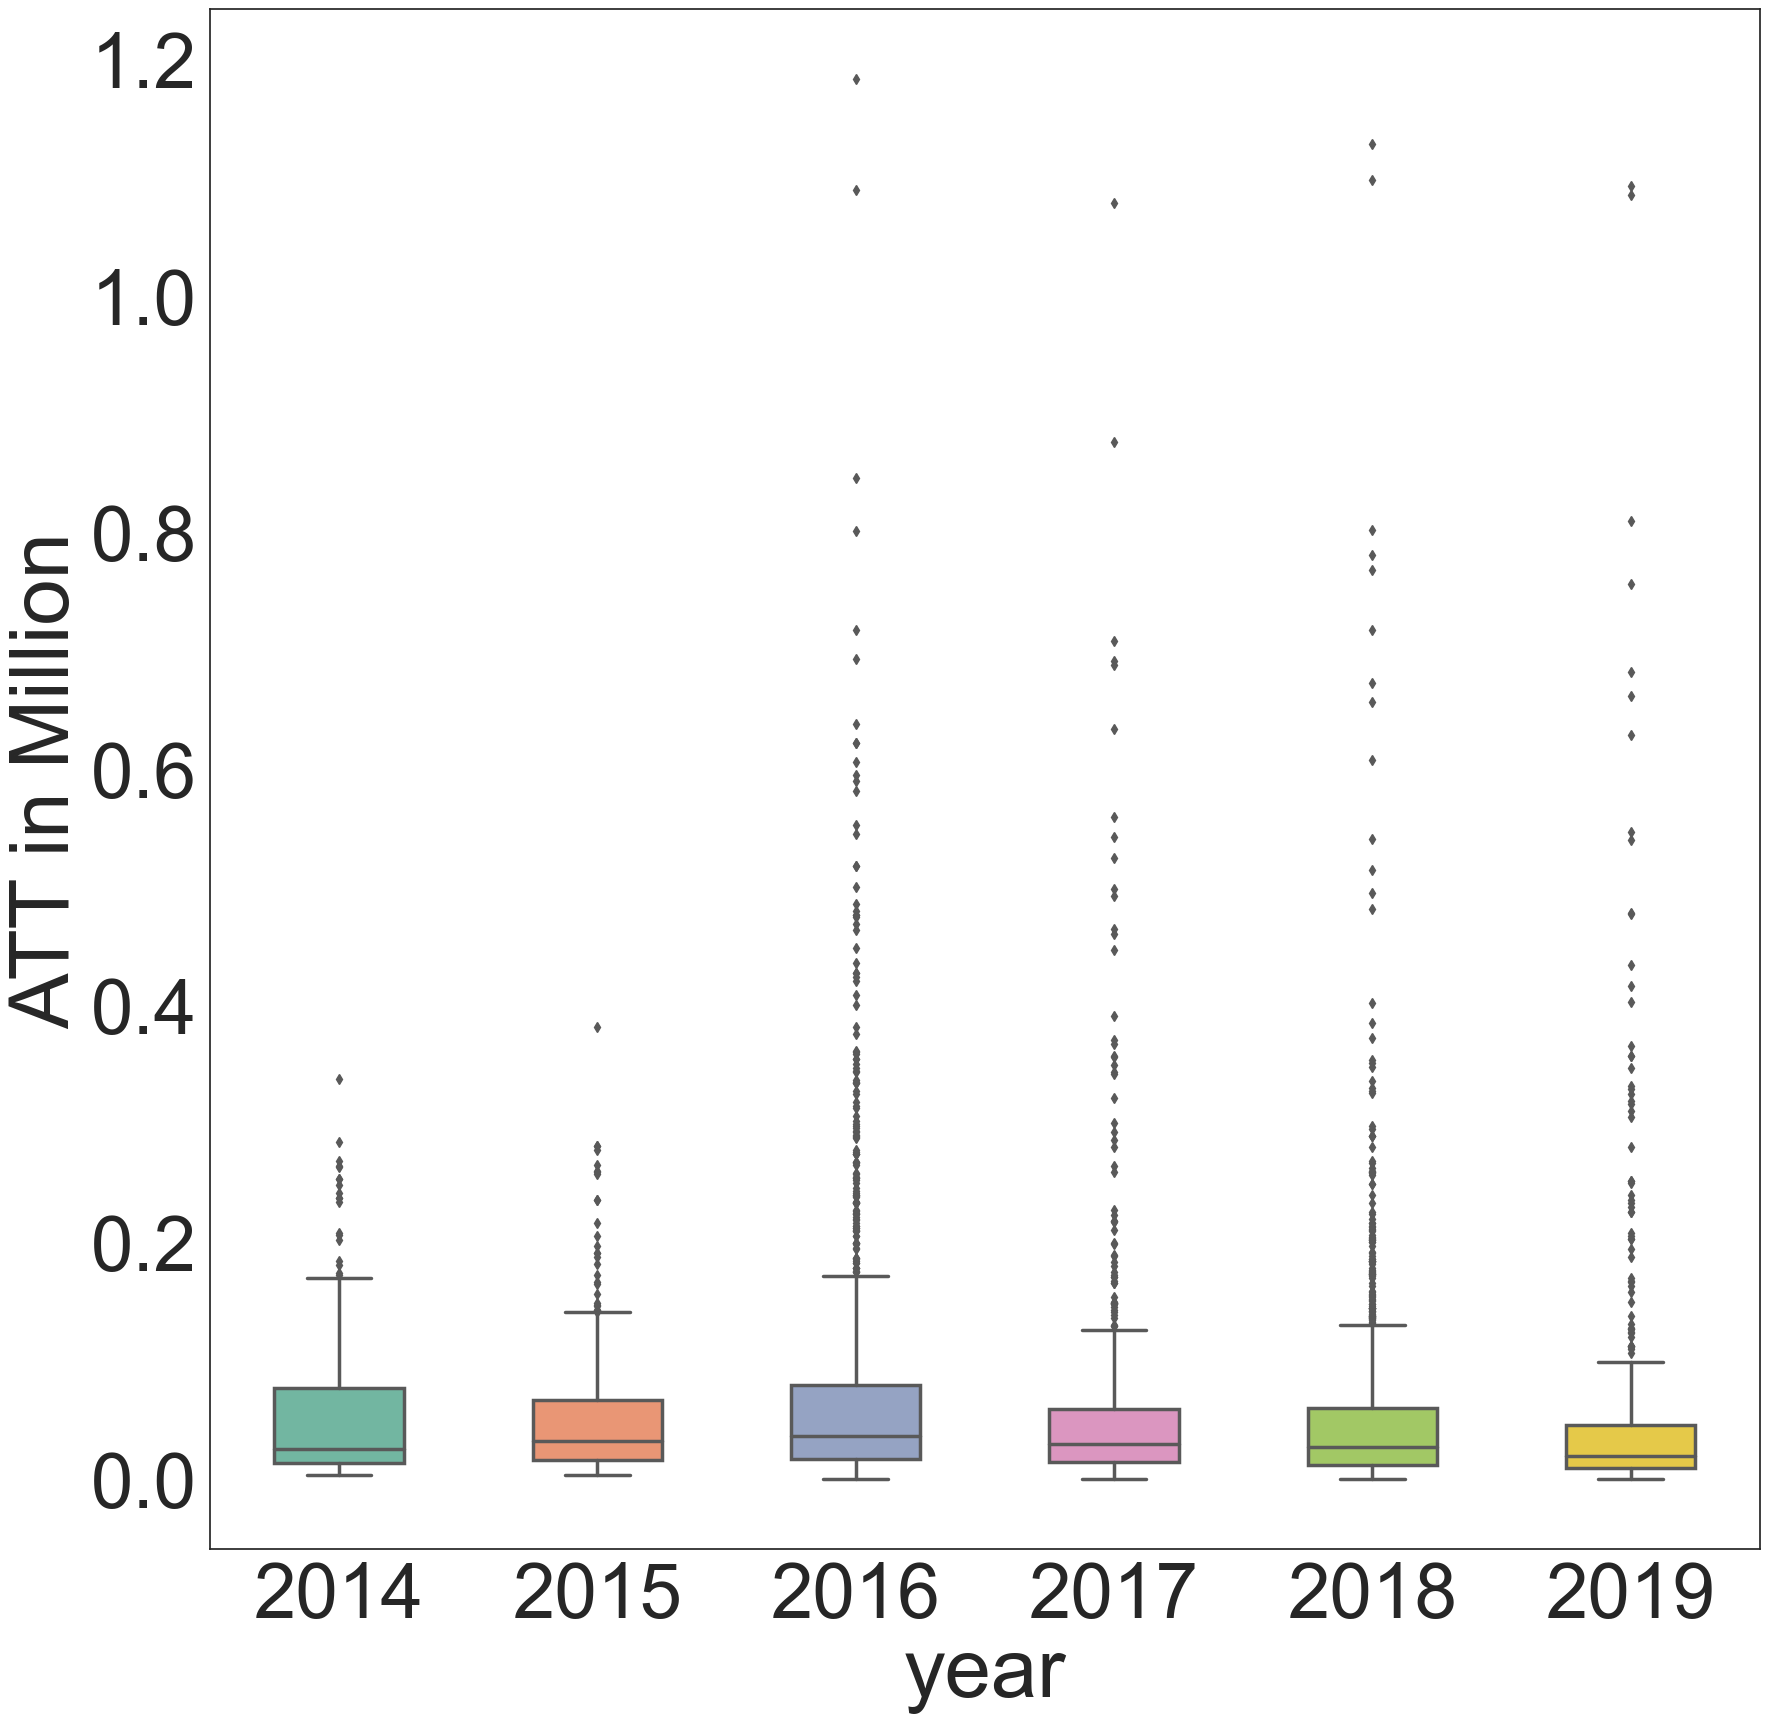

In [667]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,20)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
ax=sns.boxplot( x=model_data["year"], y=model_data["ATT in Million"],width=0.5,linewidth=2.5,orient="v",palette="Set2" );
#sns.stripplot(data=AV, x="year", y="ATT in Million", dodge=True, ax=ax)
plt.show()

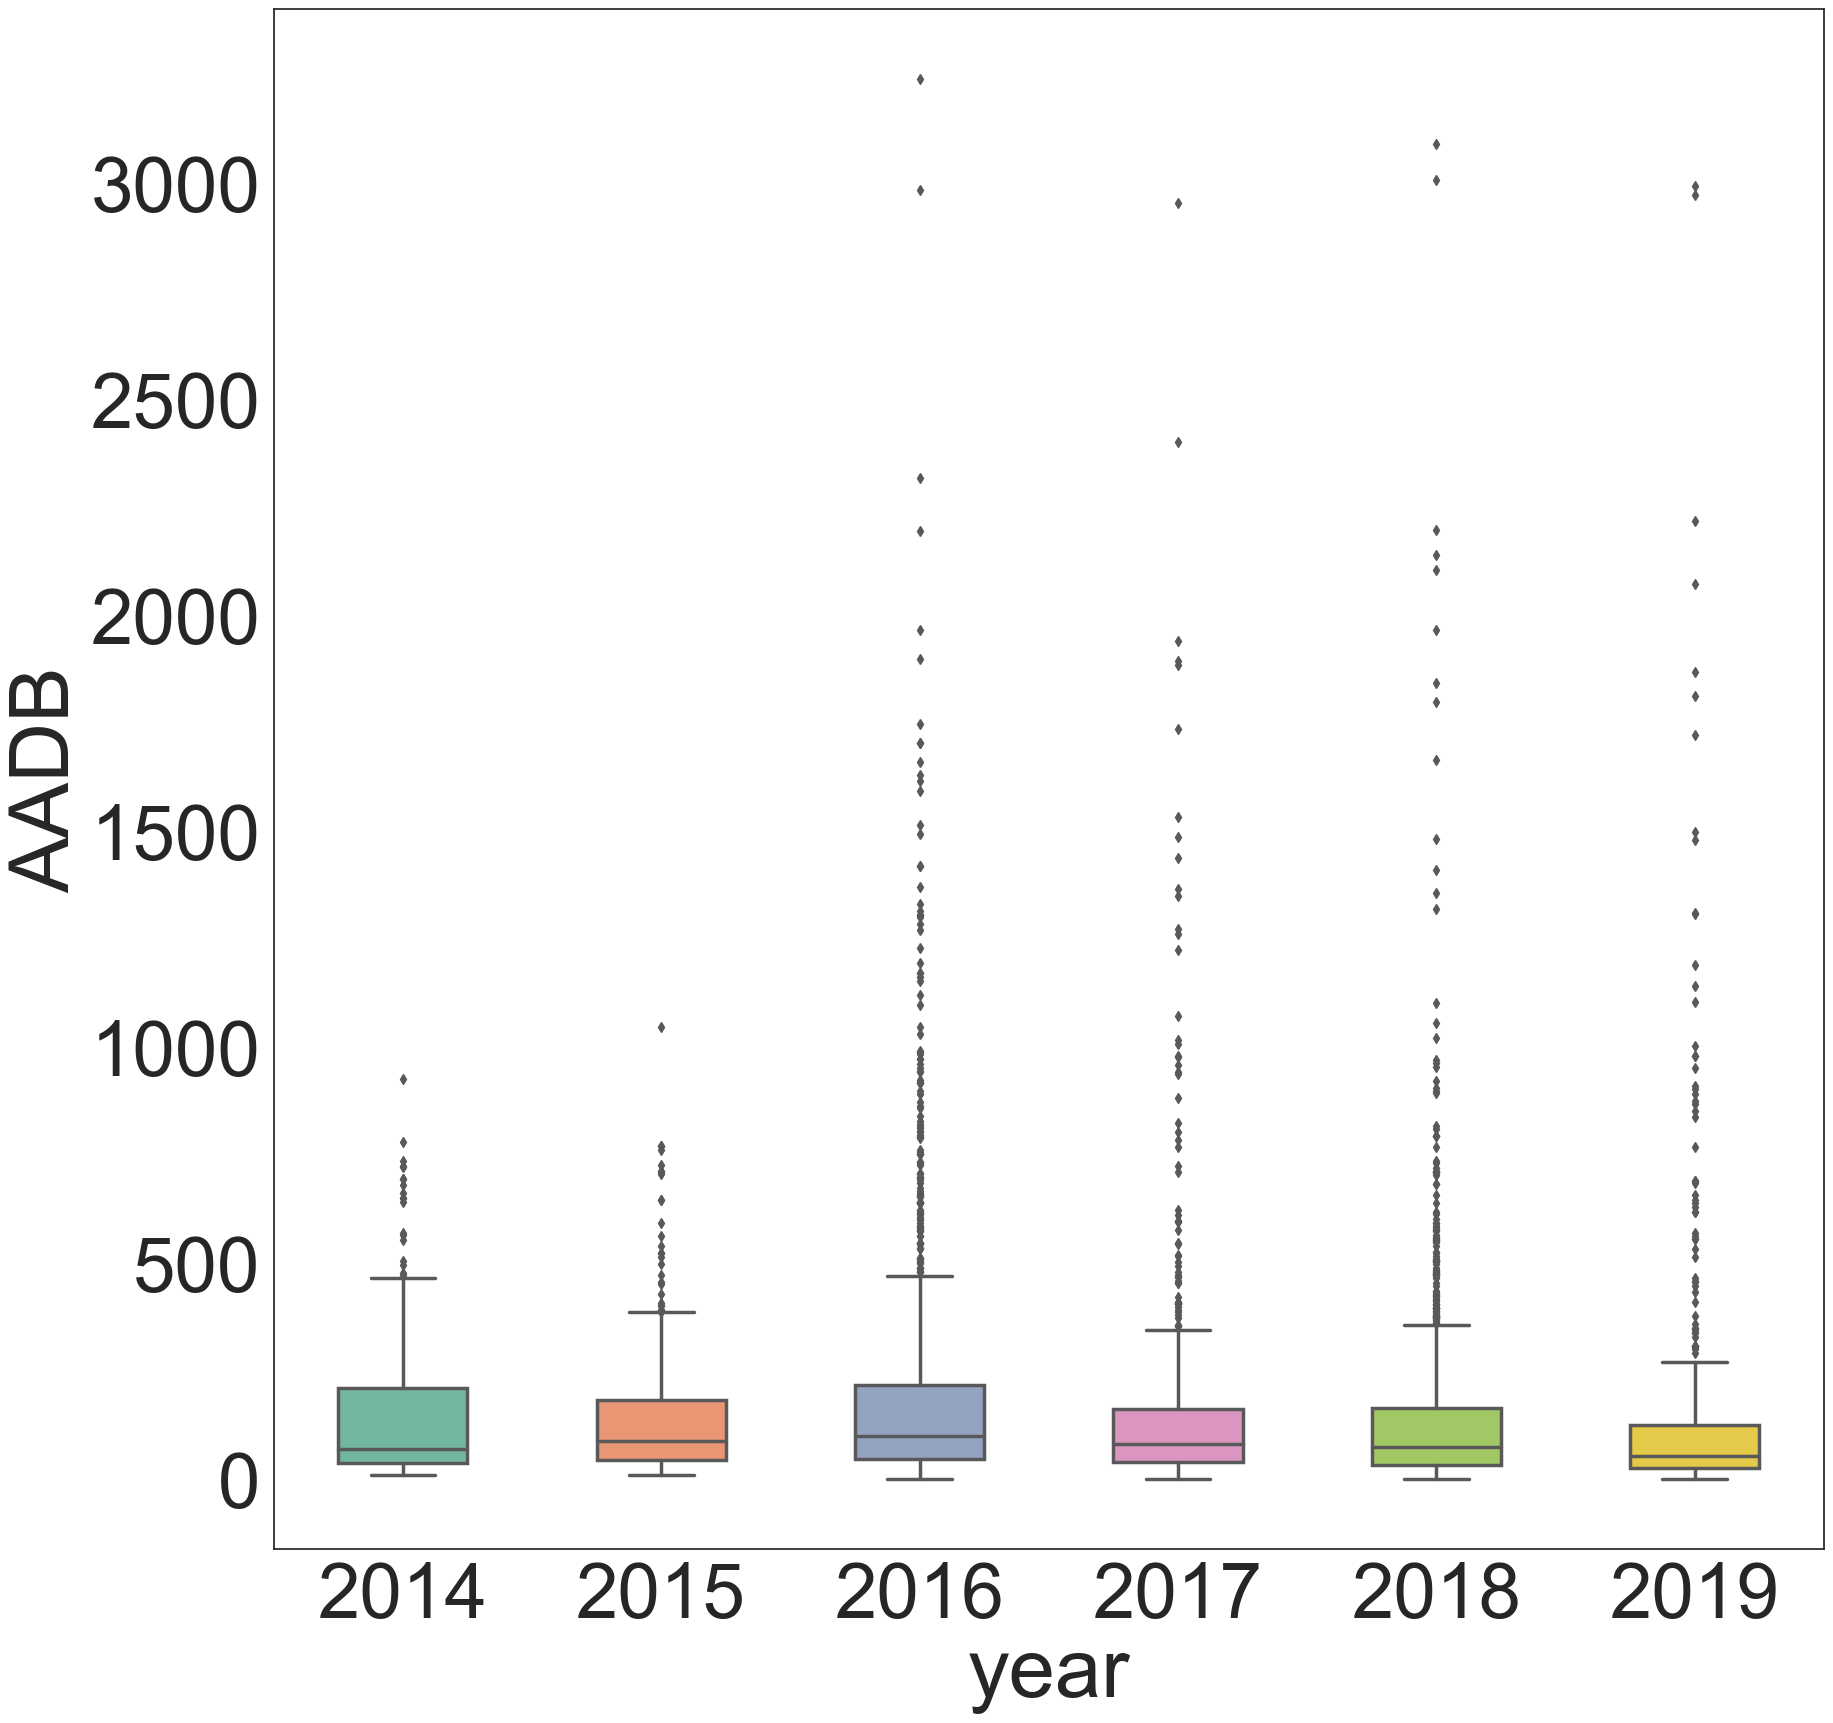

In [668]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,20)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=5, color_codes=False, rc=None)
ax=sns.boxplot( x=model_data["year"], y=model_data["AADB"],width=0.5,linewidth=2.5,orient="v",palette="Set2" );
#sns.stripplot(data=AV, x="year", y="ATT in Million", dodge=True, ax=ax)
plt.show()

In [661]:
model_data['geometry'].isnull().sum()

0

In [662]:
model_data['matched_seg_id'].isnull().sum()

3575

In [497]:
#smdata.to_csv('H:/Desktop/Bike_ped Exposure Model Project/SHS/short_term_missing_data.csv')

In [464]:
# add bike facilities
# fac=pd.read_csv('D:/Bike Exposure/Modeling/Revised_Estimatted_ATT_Feb20.csv')
# fac1=fac[['year','Leg','matched_se','Bicycle_Fa']]
# fac2=fac1.rename(columns={'matched_se':'matched_seg_id'})
# fac2.head()

In [465]:
# add Facilities
# data1=pd.merge(data, fac2, on=['year','Leg','matched_seg_id'], how='inner')
# data1.shape

In [664]:
# save the final data for modeling
model_data.to_csv('D:/Bike Exposure/Modeling/Final_data_march18.csv')

In [638]:
# Also save the shape file
# idvs=gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Independent Variables/smart4_final_output_Mar17_2023_geojson/smart4_final_output_Mar17d.geojson')
# idvs.head()

In [ ]:
# idvs.crs

In [ ]:
# idvs1=idvs[['tdg_id','geometry']]

In [ ]:
# merge the independent variable with dependent variables
# data_sh=pd.merge(data, idvs1, left_on=['matched_seg_id'], right_on=['tdg_id'],how='inner')

# data_sh=gpd.GeoDataFrame(data_sh, geometry='geometry', crs='EPSG:26910')
# data_sh1=data_sh.to_crs("epsg:4326") 
# data_sh1.head()

In [ ]:
# data_sh1.shape

In [665]:
 crs = {'init': 'epsg:4326'}
gdf_geo = gpd.GeoDataFrame(model_data, crs=crs, geometry = 'geometry')
gdf_geo.to_file("H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_PC_SC_ATT_march18.shp")

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12612\563833614.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_geo.to_file("H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_PC_SC_ATT_march18.shp")


In [666]:
gdf_geo.to_file("H:/Desktop/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT_march18.geojson", driver='GeoJSON')

# end of the Script